# Imputación Multi-Variable de Datos Meteorológicos

Este notebook procesa múltiples variables (precipitación, temperaturas, caudales)
utilizando métodos de regresión para imputar datos faltantes.

In [1]:
import sys
sys.path.append('.')

import imputation_pipeline as pipeline
import visualization
import homogeneity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Configuración

In [ ]:
# Configuración global con listas paralelas por variable
config = {
    'out_dir': '../output',
    'dem_path': '../data/dem/DEM.tif',
    'methods': ['RF'],  # Métodos: 'SLR', 'MLR', 'LWR', 'RF' (pueden ser varios)
    'cv_sample_fraction': 0.05,
    'nearstn_min': 2,
    'try_radius': 150,
    'initial_distance': 100,
    'min_valid_neighbors': 2,
    
    # Configuración por variable (listas paralelas)
    # Orden: prcp DEBE ser primero (flow lo necesita como predictor)
    'variables': ['prcp', 'tmax', 'tmin', 'flow'],
    'csv_path': [
        '../data/01_prcp.csv', 
        '../data/02_tmax.csv', 
        '../data/03_tmin.csv', 
        '../data/04_flow.csv'
    ],
    'use_boxcox': [True, False, False, True],
    'exp': [0.25, None, None, 0.25],
    'minRange': [0, -40, -40, 0],
    'maxRange': [300, 50, 50, 1000],
    'nearstn_max': [30, 30, 30, 30],
    'predictors': ['self', 'self', 'self', 'prcp+flow'],
    'results_nc': [
        '../output/imputation_results_prcp.nc', 
        '../output/imputation_results_tmax.nc', 
        '../output/imputation_results_tmin.nc', 
        '../output/imputation_results_flow.nc'
    ],
}

print("=== CONFIGURACIÓN ===")
print(f"Variables: {config['variables']}")
print(f"Métodos: {config['methods']}")

=== CONFIGURACIÓN ===
Variables: ['prcp', 'tmax', 'tmin', 'flow']
Métodos: ['RF']


## 2. Procesamiento

Ejecuta la imputación para todas las variables y métodos configurados.

In [3]:
# Procesar todas las variables
all_results = pipeline.process_all_variables(config)


=== INICIANDO PROCESAMIENTO MULTI-VARIABLE ===

Variables: ['prcp', 'tmax', 'tmin', 'flow']
Métodos: ['RF']

  PROCESANDO: PRCP
  Cargando desde: ../output/imputation_results_prcp.nc
Cargando datos de prcp desde: ../01_prcp.csv
  Dimensiones: Frozen({'time': 18566, 'stn': 10}), Variable: prcp
Extrayendo predictores del DEM: ../DEM/DEM.tif
  elev_dem: rango [2506.2, 4894.2] m
  slp_n: rango [-0.0969, 0.1672]
  slp_e: rango [-0.0735, 0.1025]
    RF: Cargado

  PROCESANDO: TMAX
  Cargando desde: ../output/imputation_results_tmax.nc
Cargando datos de tmax desde: ../02_tmax.csv
  Dimensiones: Frozen({'time': 18566, 'stn': 7}), Variable: tmax
Extrayendo predictores del DEM: ../DEM/DEM.tif
  elev_dem: rango [2506.2, 4257.1] m
  slp_n: rango [-0.0969, 0.1672]
  slp_e: rango [-0.0066, 0.1026]
    RF: Cargado

  PROCESANDO: TMIN
  Cargando desde: ../output/imputation_results_tmin.nc
Cargando datos de tmin desde: ../03_tmin.csv
  Dimensiones: Frozen({'time': 18566, 'stn': 9}), Variable: tmin
Ext

c:\Users\Kevin\AppData\Local\Programs\Python\Python313\Lib\site-packages\rasterio\transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype="int32")
c:\Users\Kevin\AppData\Local\Programs\Python\Python313\Lib\site-packages\rasterio\transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype="int32")


## 3. Estadísticas Básicas

Métricas estadísticas para todas las variables.

In [4]:
# Estadísticas básicas de todas las variables
df_stats = pipeline.compute_basic_statistics(config, all_results)
display(df_stats)


=== ESTADÍSTICAS BÁSICAS ===

  prcp...
  tmax...
  tmin...
  flow...

Guardado: ../output\ESTADISTICAS_BASICAS.csv


Variable      Tipo Método   N_Obs  N_Missing  Pct_Missing     Mean      Std  \
0     prcp  Original      -  148768      36892        19.87   1.4898   4.1061   
1     prcp  Imputado     RF  185660          0         0.00   1.3420   3.7689   
2     tmax  Original      -   67563      62399        48.01  18.0759   3.9108   
3     tmax  Imputado     RF  129899         63         0.05  18.3353   4.4013   
4     tmin  Original      -   70499      96595        57.81  -0.3490   5.5973   
5     tmin  Imputado     RF  129962      37132        22.22   0.2688   5.7990   
6     flow  Original      -   22702      70128        75.54  23.1557  52.5058   
7     flow  Imputado     RF   92830          0         0.00  10.7679  29.9807   

    Min     Max  
0   0.0    88.3  
1   0.0    88.3  
2   2.0    31.2  
3   2.0    31.2  
4 -19.2    16.6  
5 -19.2    16.6  
6   0.0  1000.0  
7   0.0  1000.0

## 4. Evaluación (Validación Cruzada)

Validación cruzada para TODAS las variables (prcp, tmax, tmin, flow).
Las métricas se calculan ocultando datos conocidos y comparando predicciones.

In [5]:
# Evaluar TODAS las variables con CV
df_metrics = pipeline.evaluate_all_variables(config, all_results)

# Mostrar tabla pivote
if len(df_metrics) > 0:
    df_pivot = df_metrics.pivot_table(
        index=['Variable', 'Metric'], 
        columns='Method', 
        values='Value'
    ).round(2)
    display(df_pivot)


=== EVALUACIÓN CON VALIDACIÓN CRUZADA ===

Cargando métricas desde: ../output\COMPARACION_METODOS_MULTI.csv


Method              RF
Variable Metric       
flow     ARB      1.02
         CC       0.05
         CSI      1.00
         FAR      0.00
         FOH      1.00
...                ...
tmin     NSE      0.89
         PBIAS  -41.45
         POD      0.91
         RB      -0.41
         RMSE     1.89

[66 rows x 1 columns]

## 5. Visualización


=== VISUALIZACIÓN POR VARIABLE ===


--- prcp: RF ---


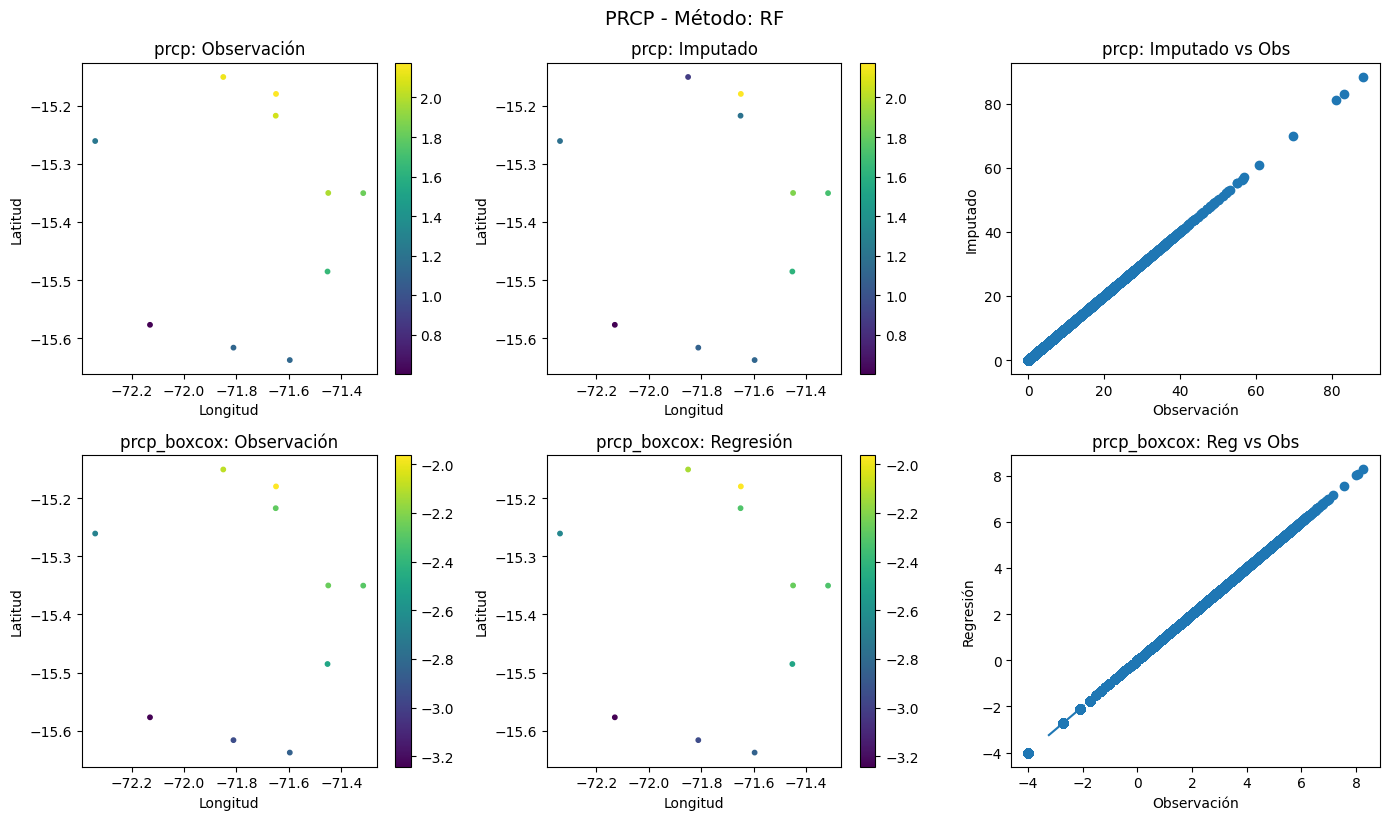


--- tmax: RF ---


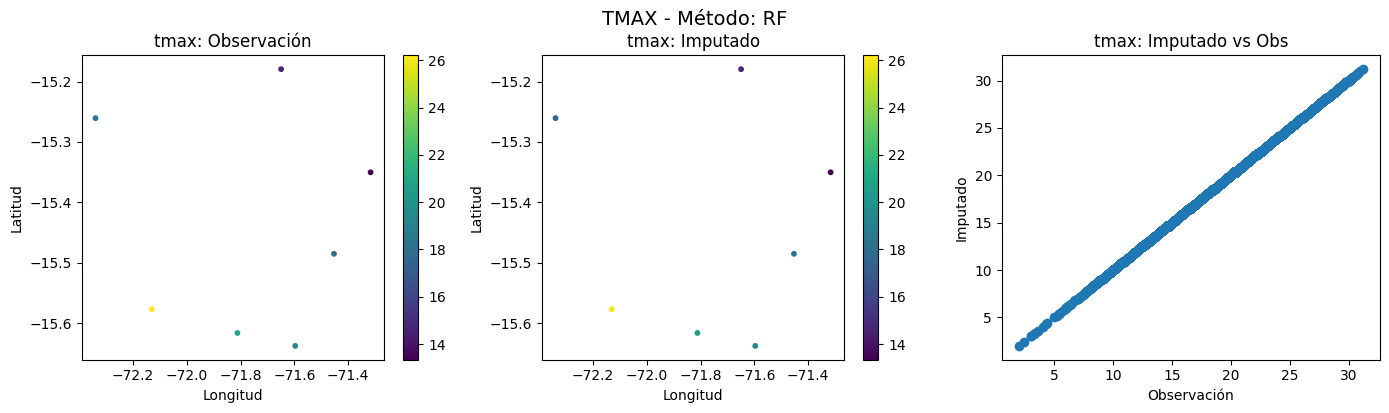


--- tmin: RF ---


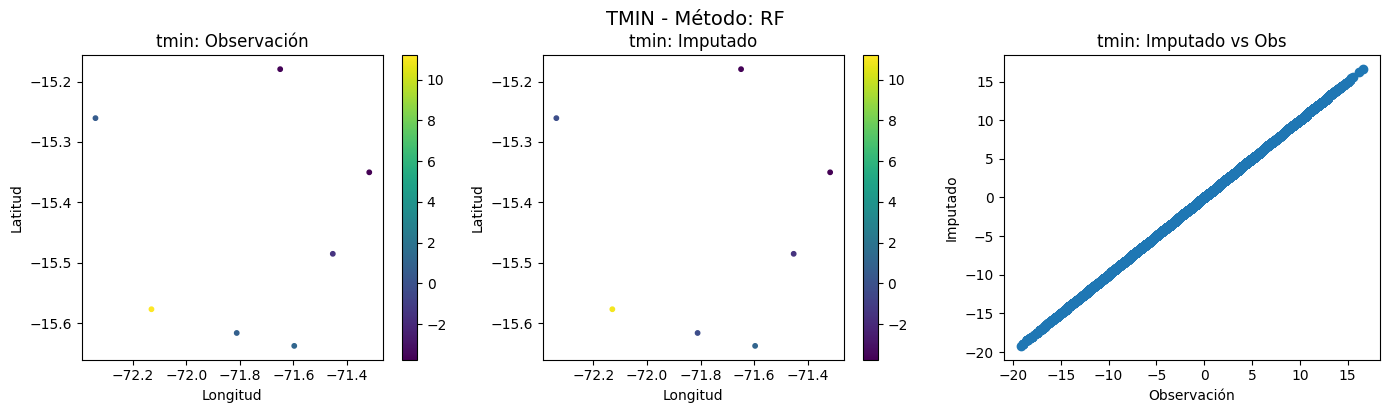


--- flow: RF ---


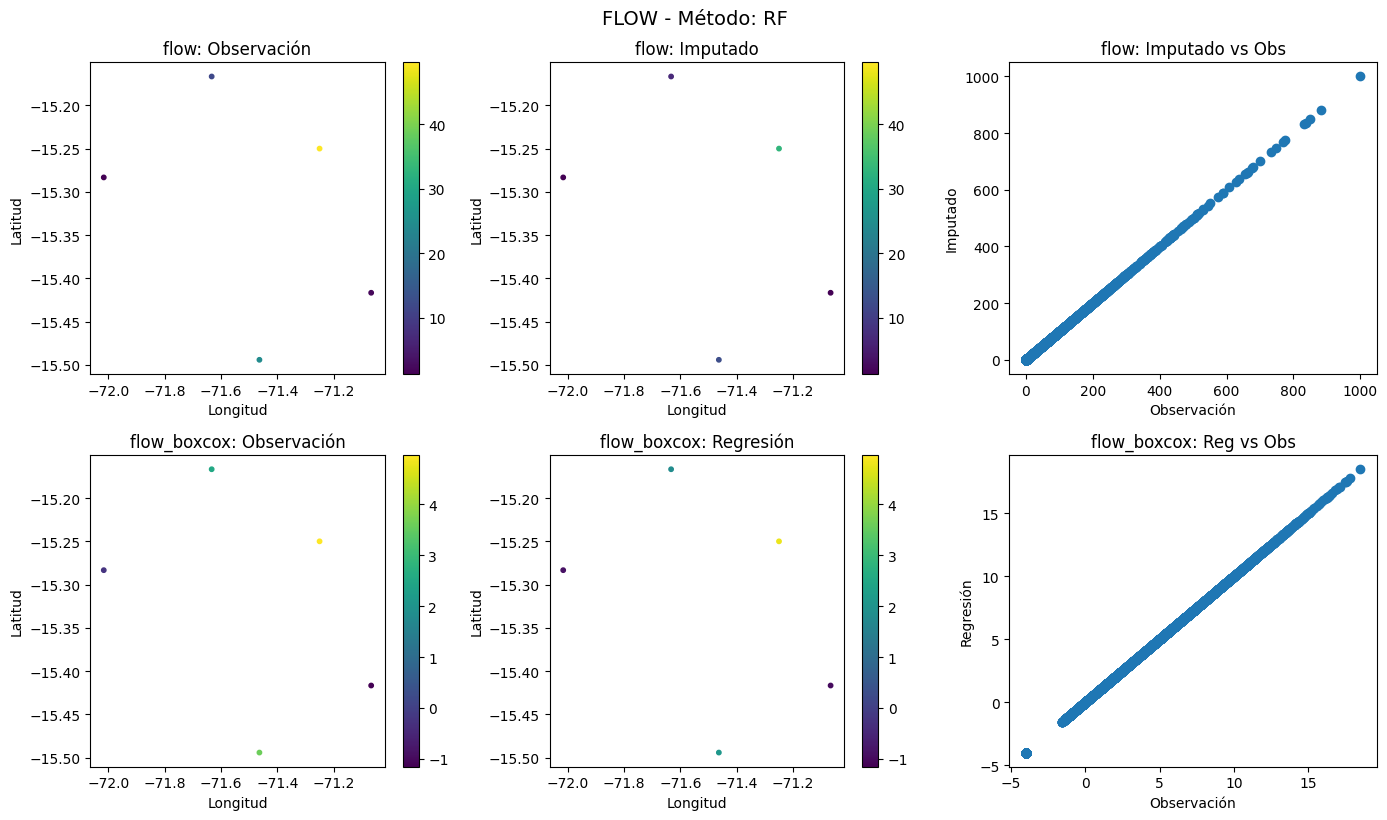

In [6]:
# Visualizar todas las variables
visualization.plot_all_results(config, all_results)

## 6. Series Temporales


=== SERIES TEMPORALES ===


--- prcp: RF ---


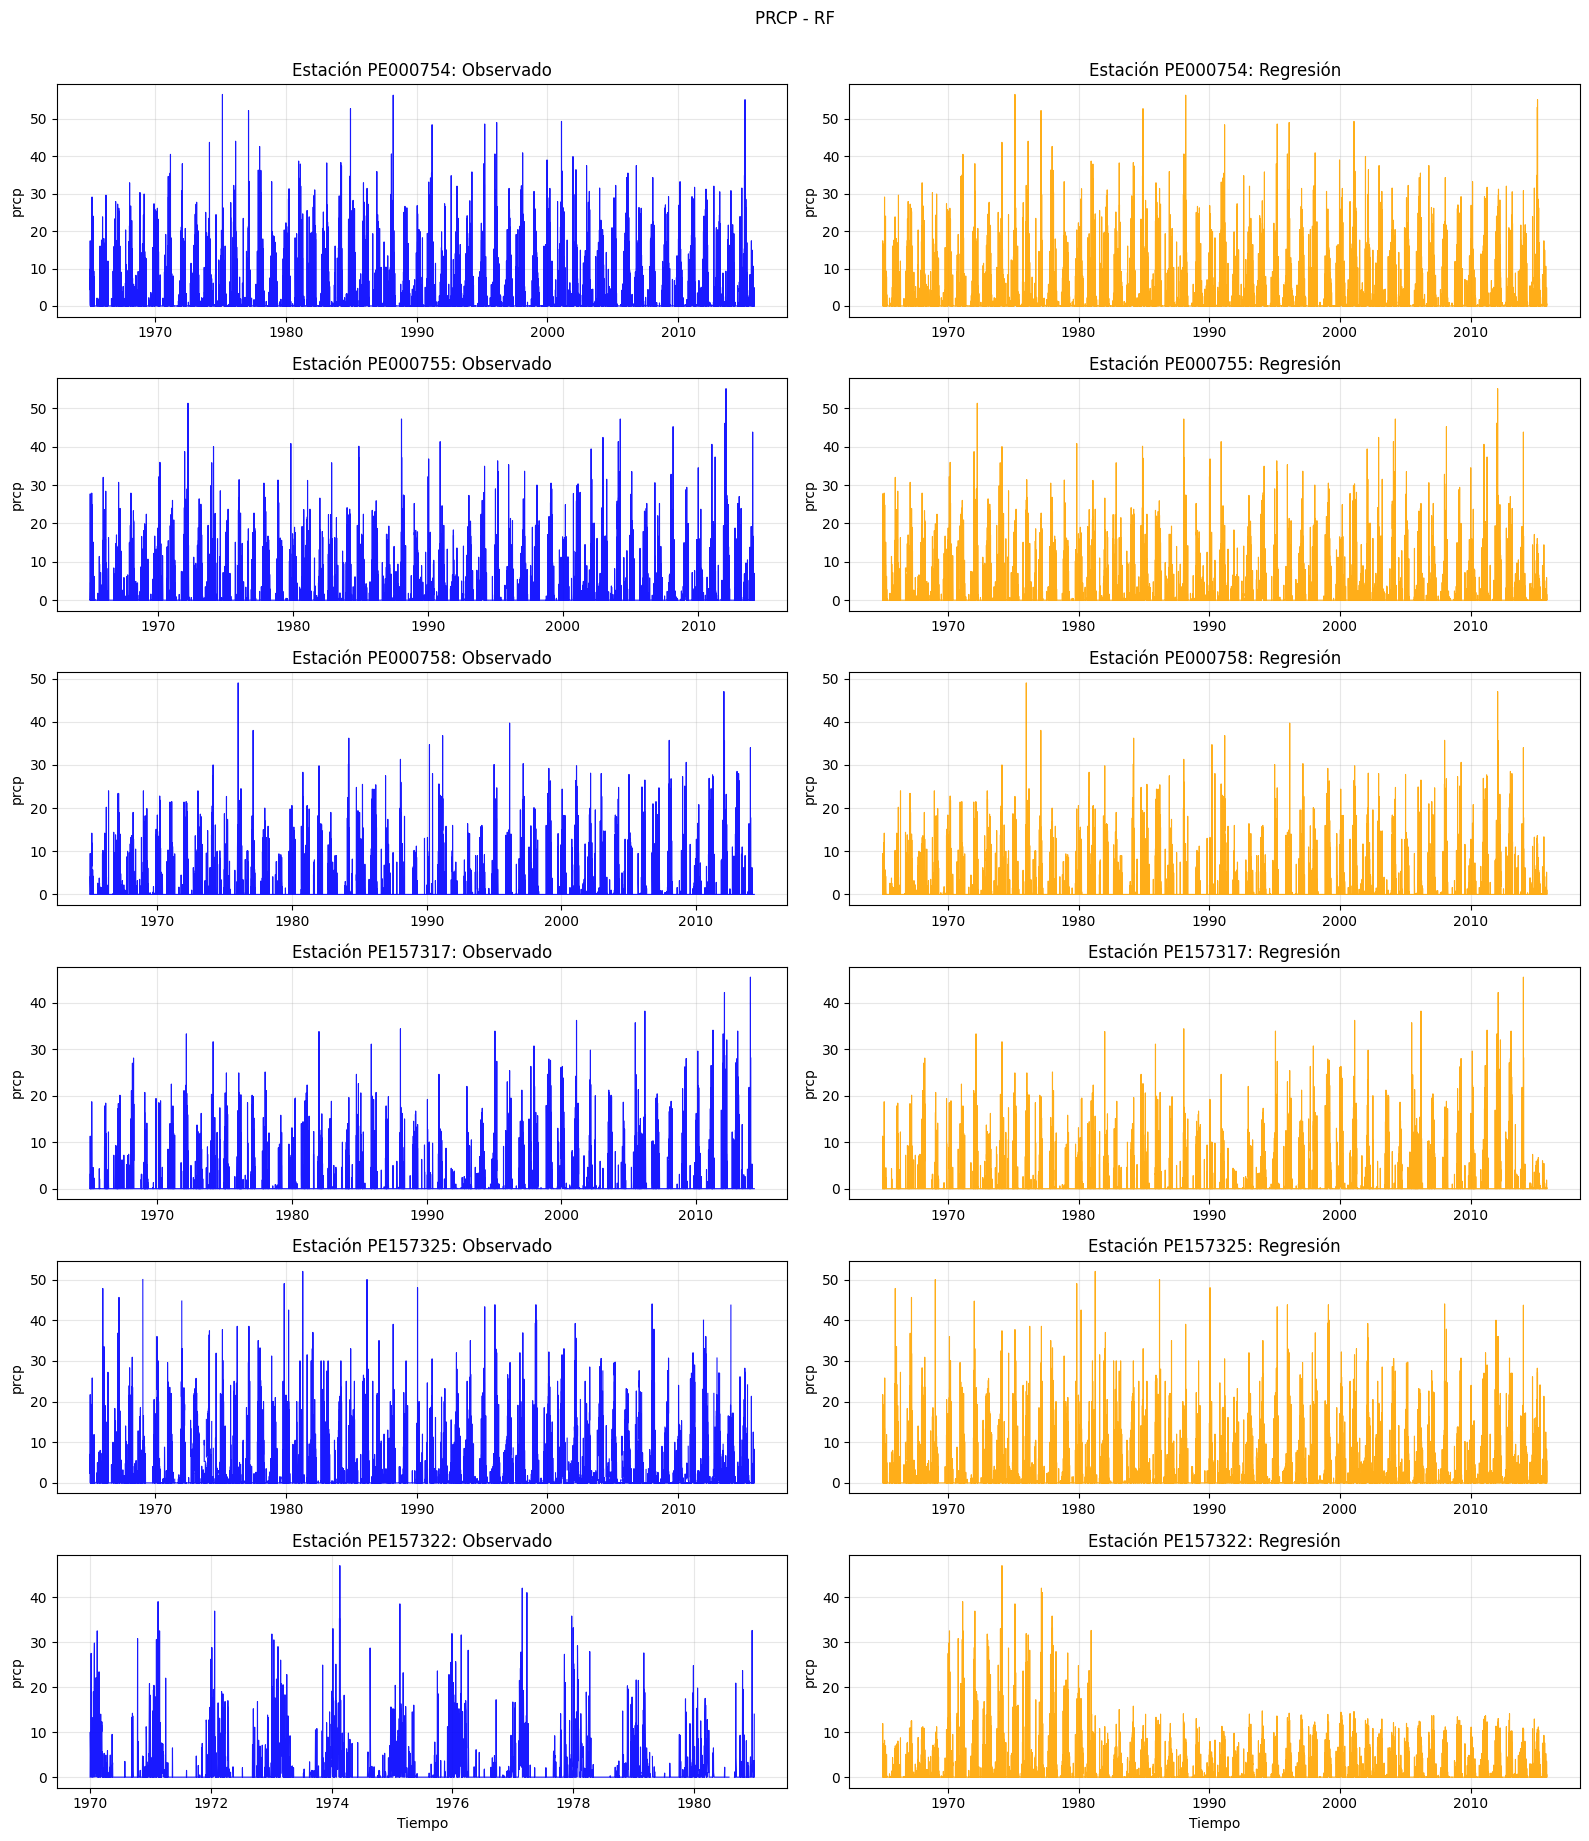


--- tmax: RF ---


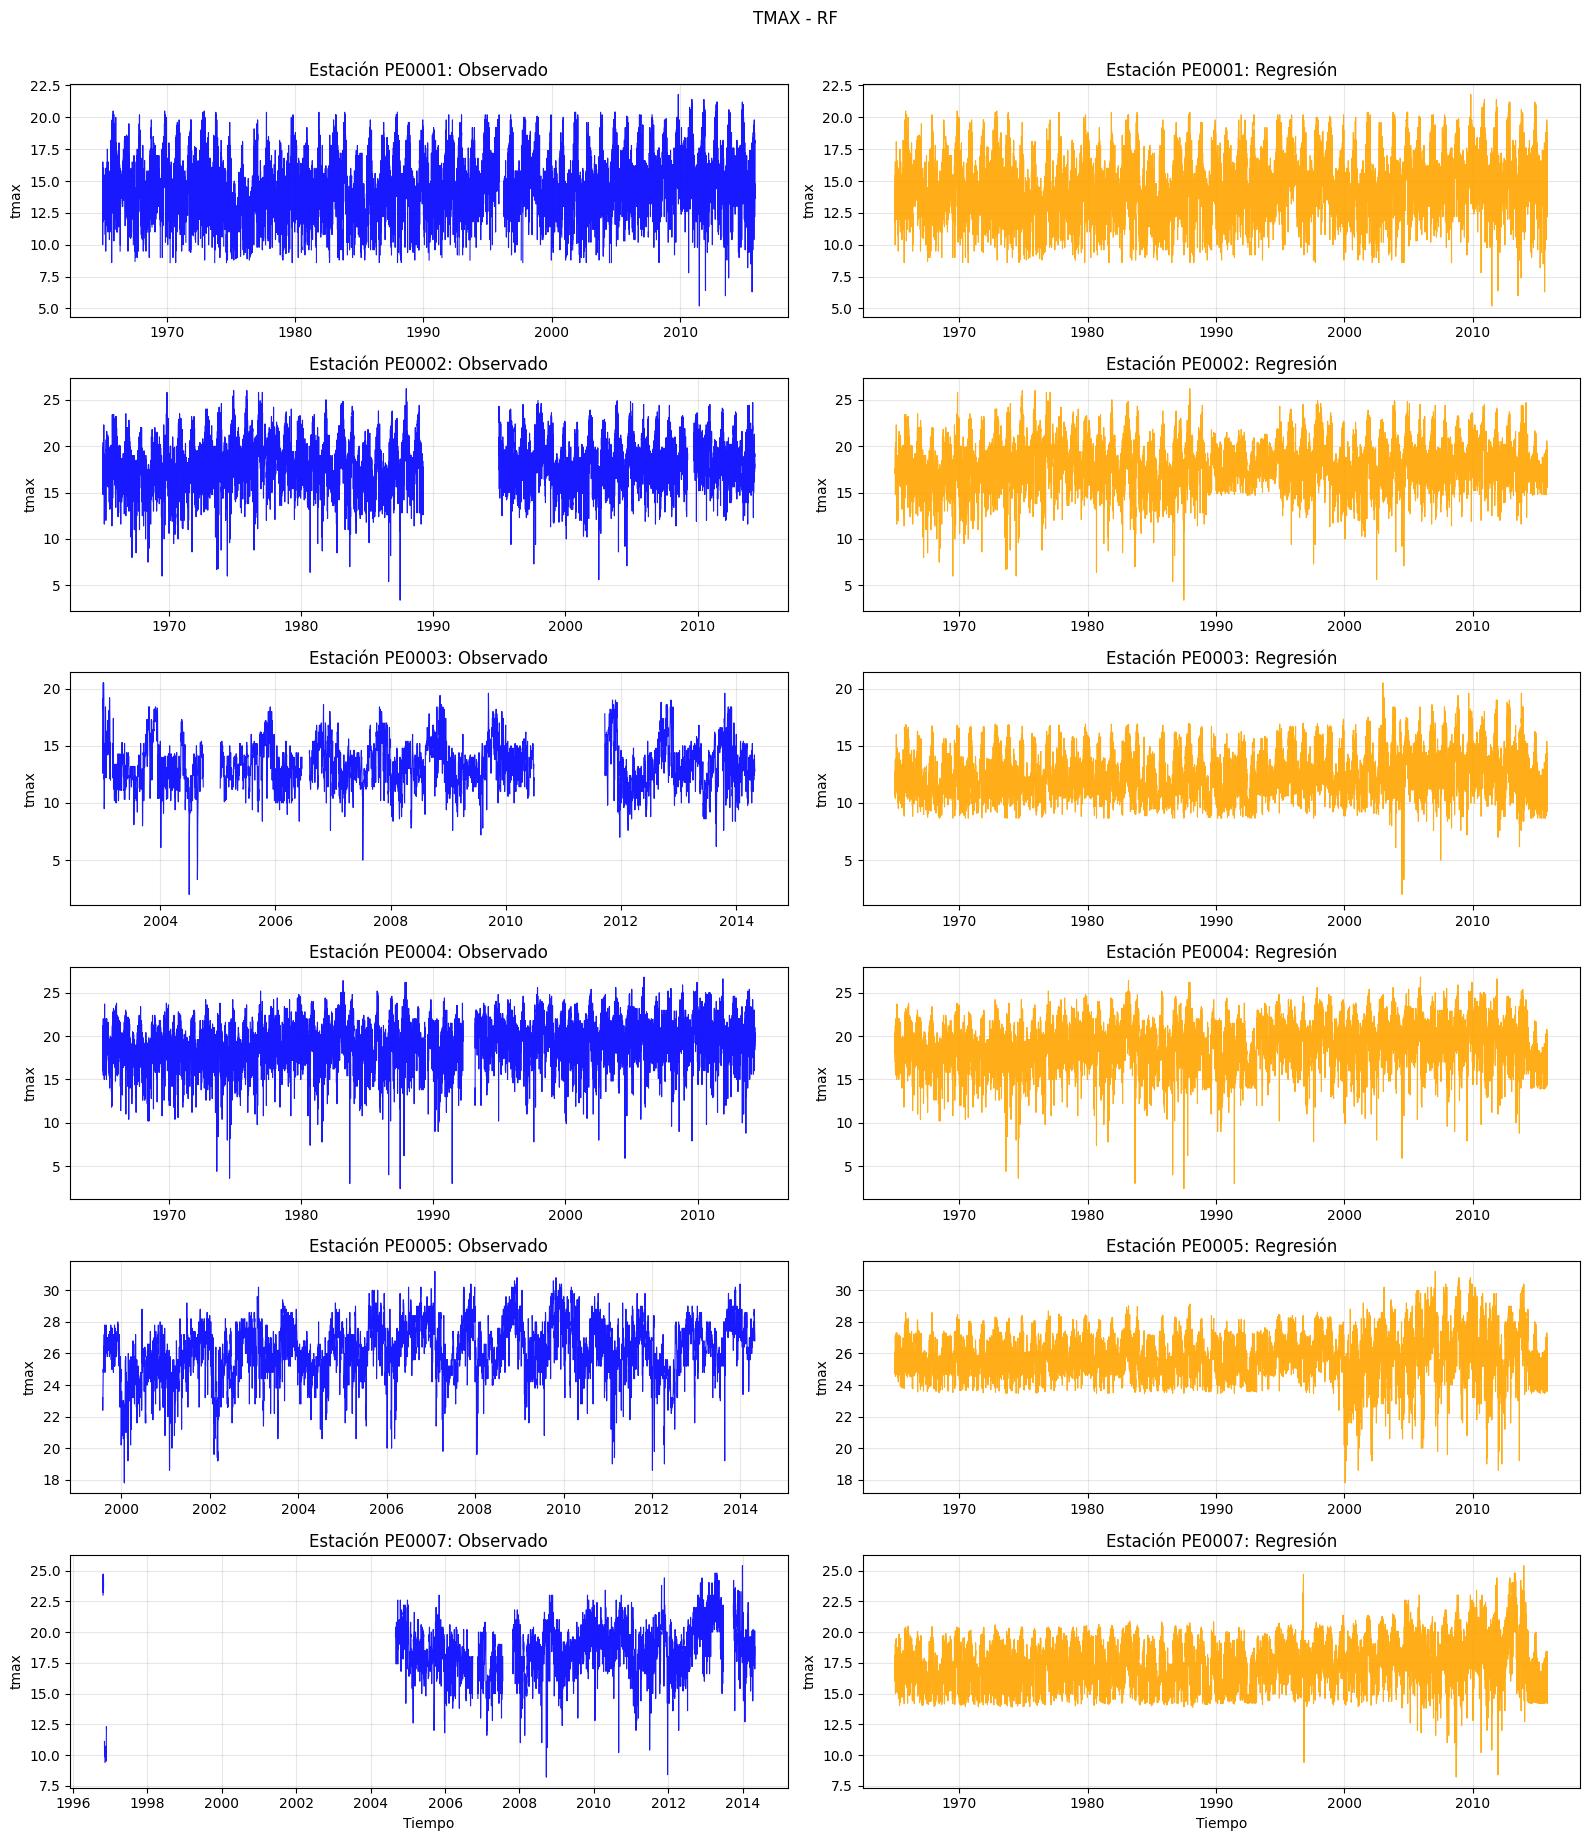


--- tmin: RF ---


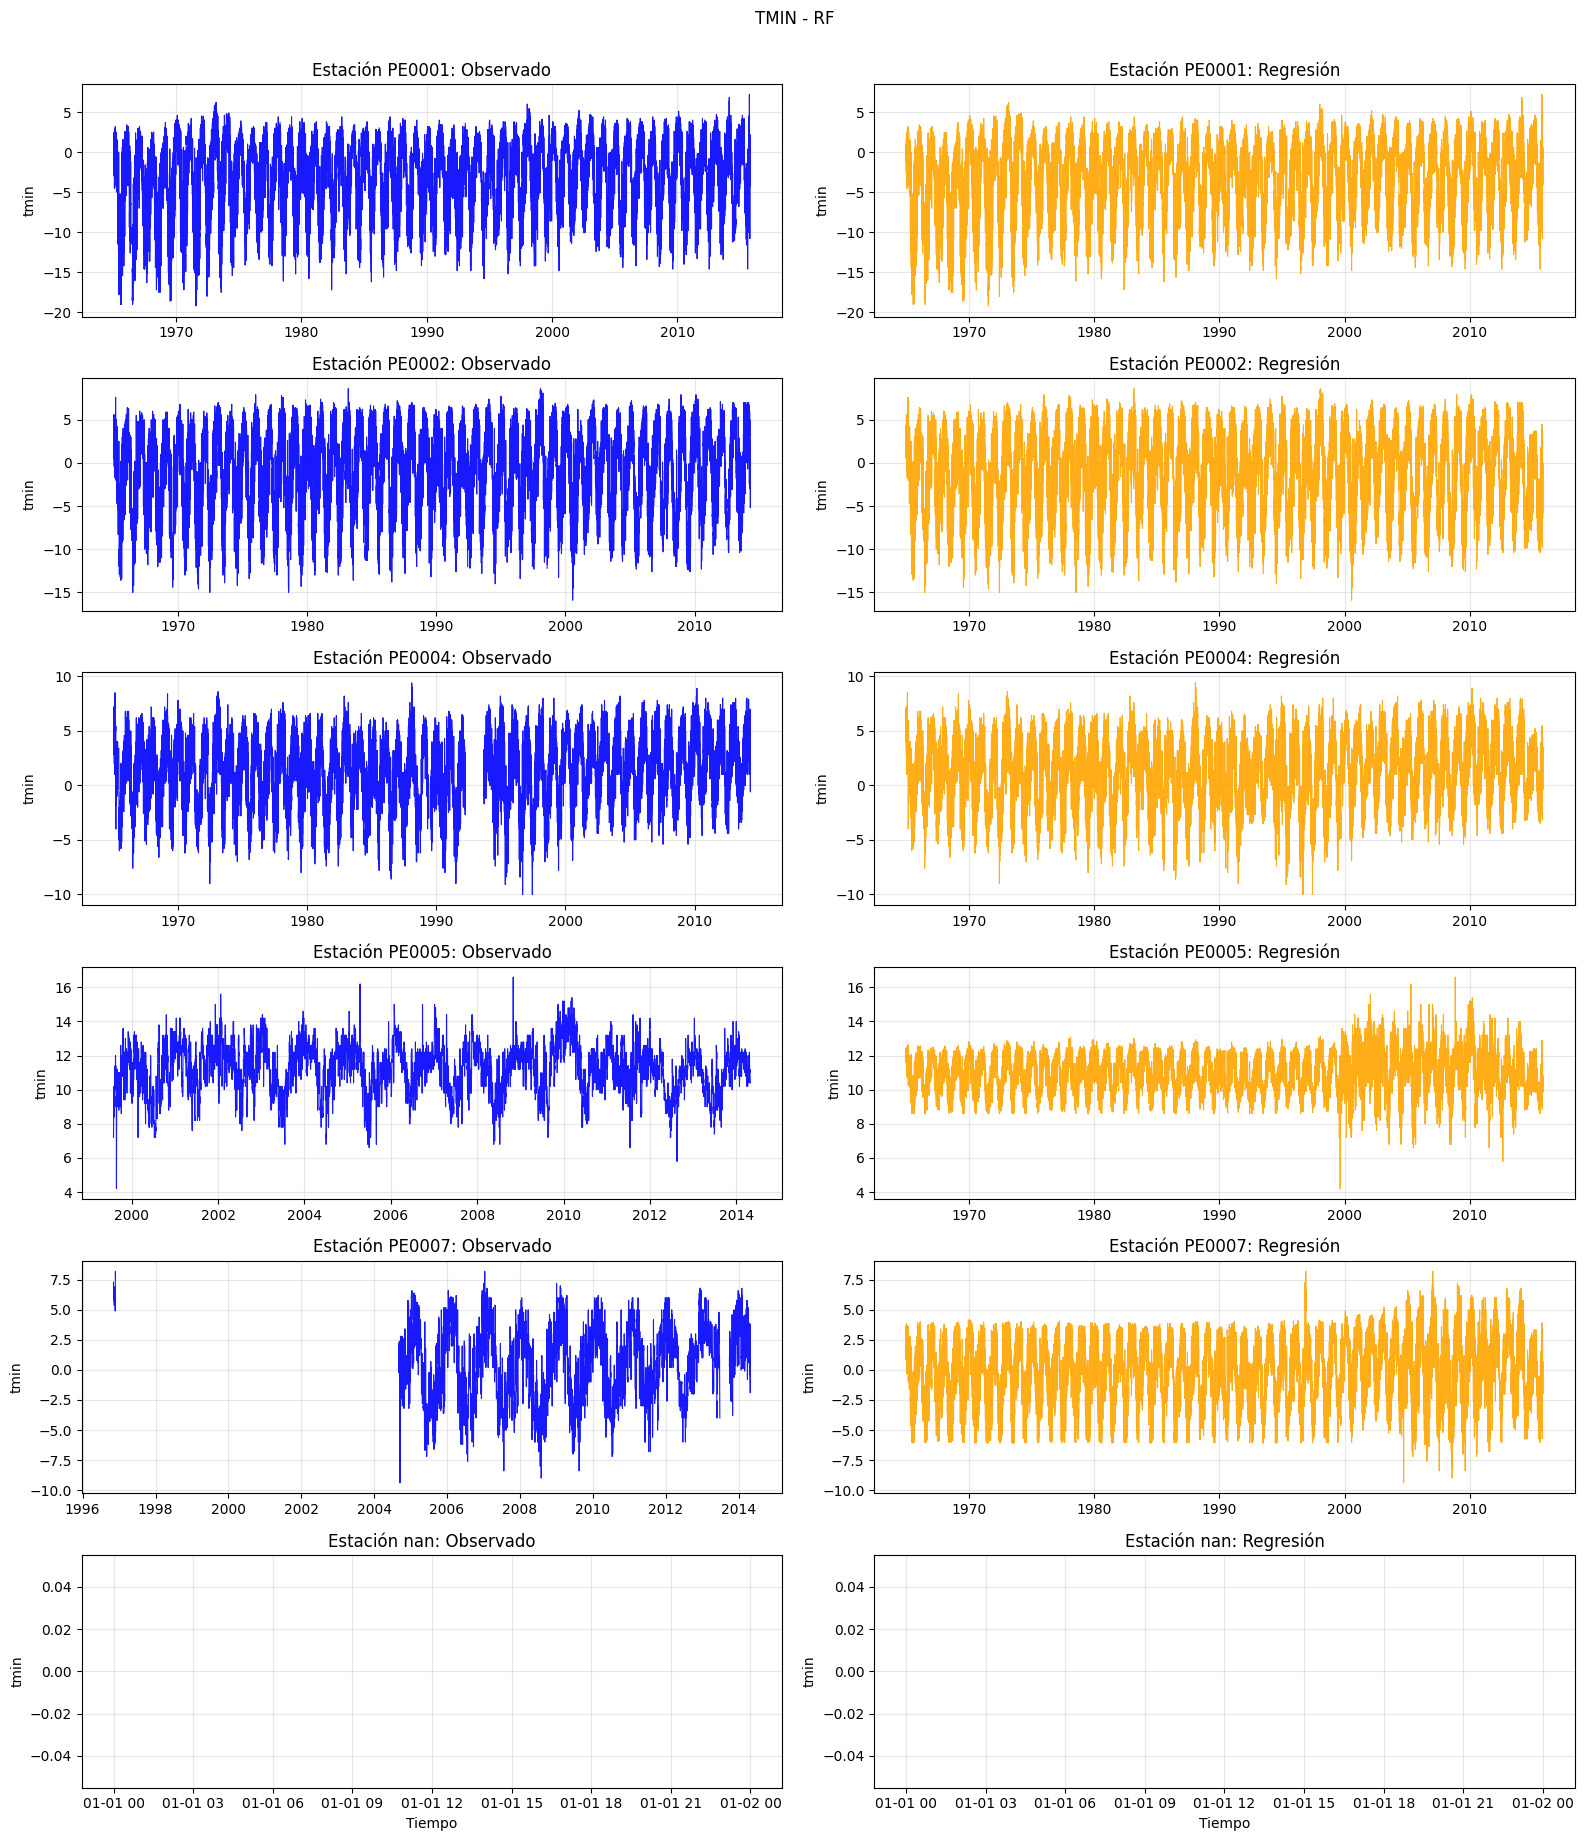


--- flow: RF ---


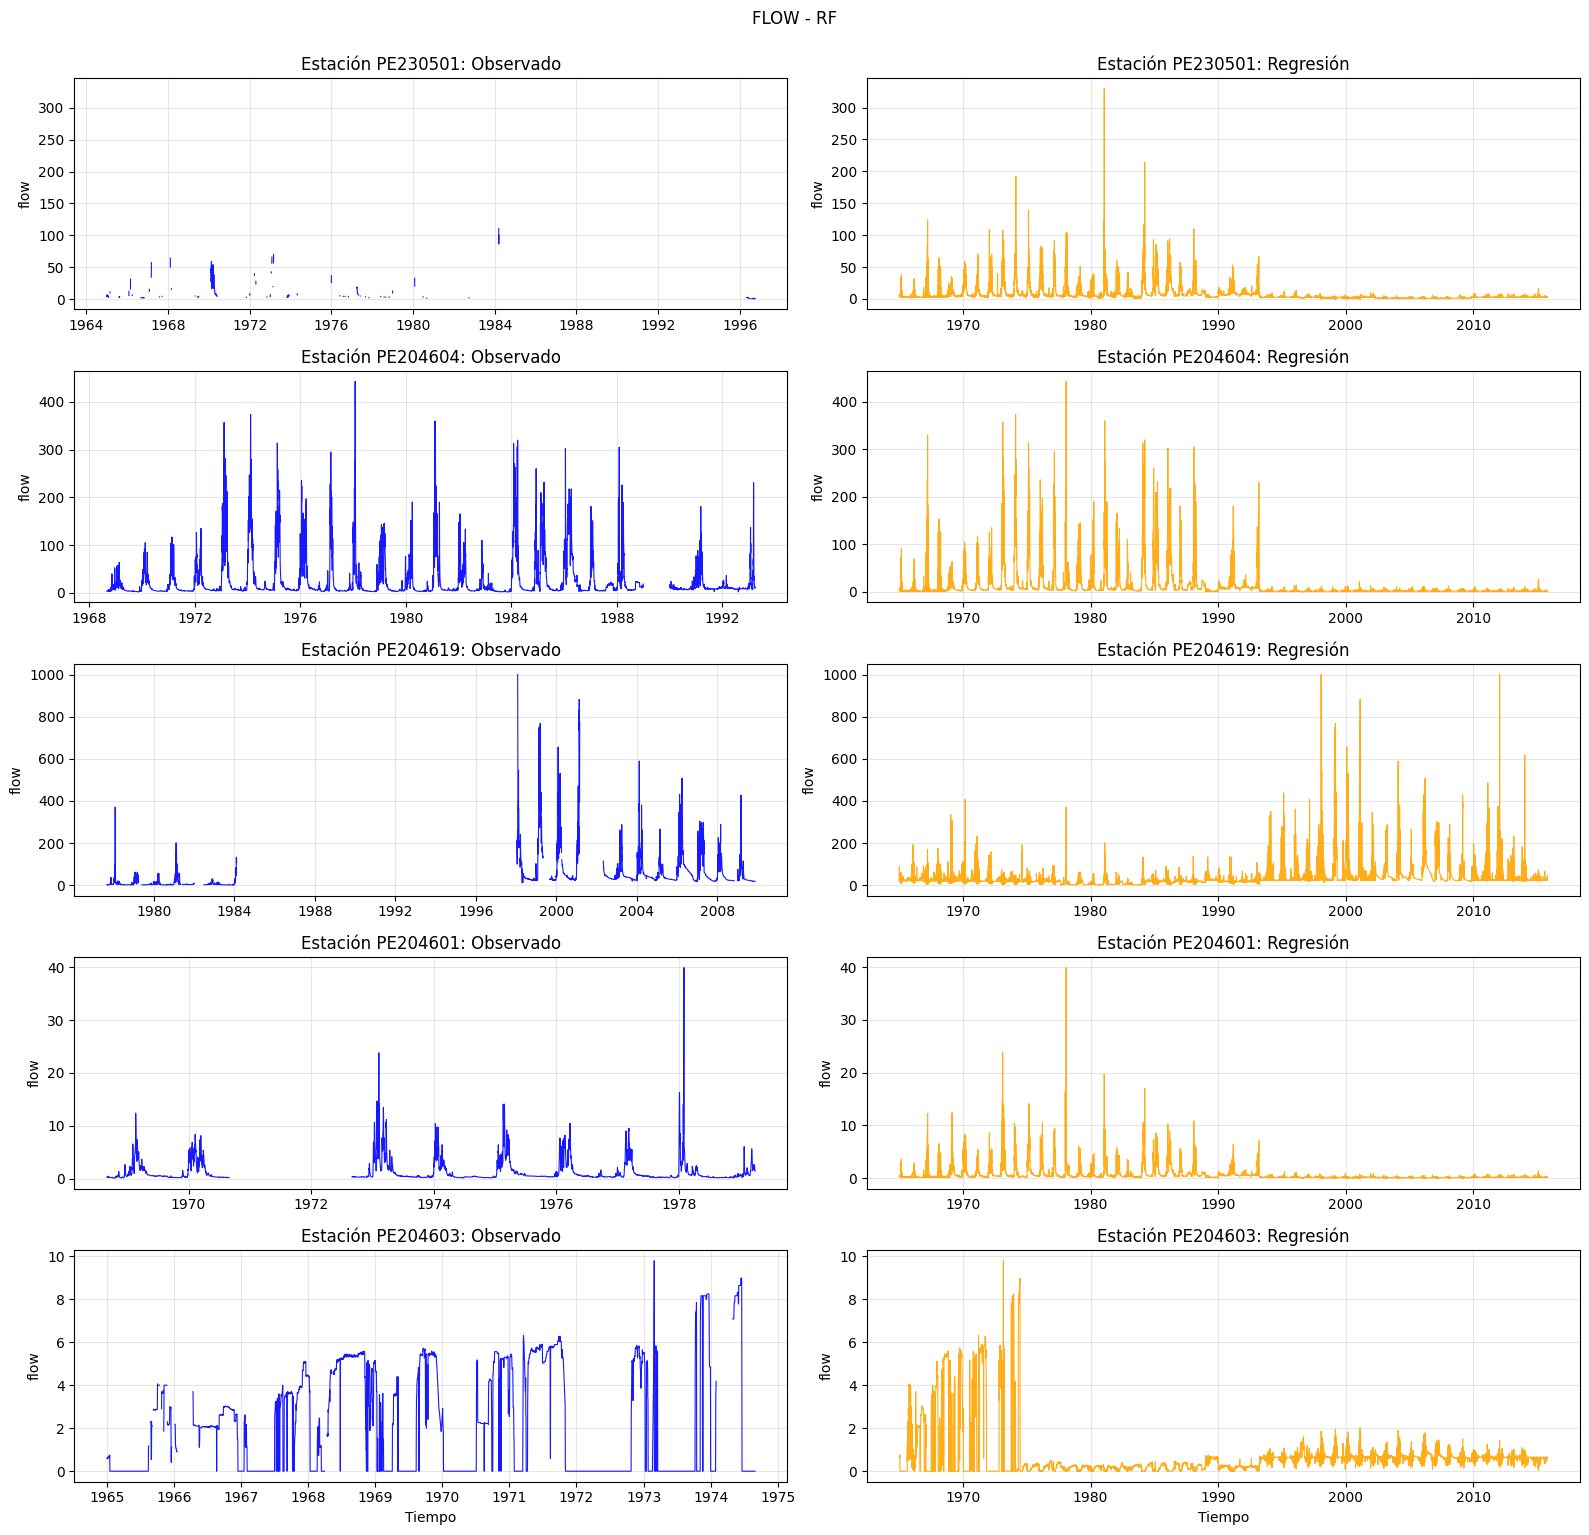

In [7]:
# Series temporales de todas las variables
visualization.plot_all_time_series(config, all_results, n_stations=6)

## 7. Pruebas de Homogeneidad

Análisis de homogeneidad (Buishand U-test y SNHT) para detectar puntos de quiebre.
Muestra todas las estaciones seleccionadas en una figura por frecuencia.


  HOMOGENEIDAD: PRCP

  Método: RF
  Estaciones: ['PE000754', 'PE000755', 'PE000758', 'PE157317', 'PE157325', 'PE157322']

  Análisis Diario (6 estaciones)...


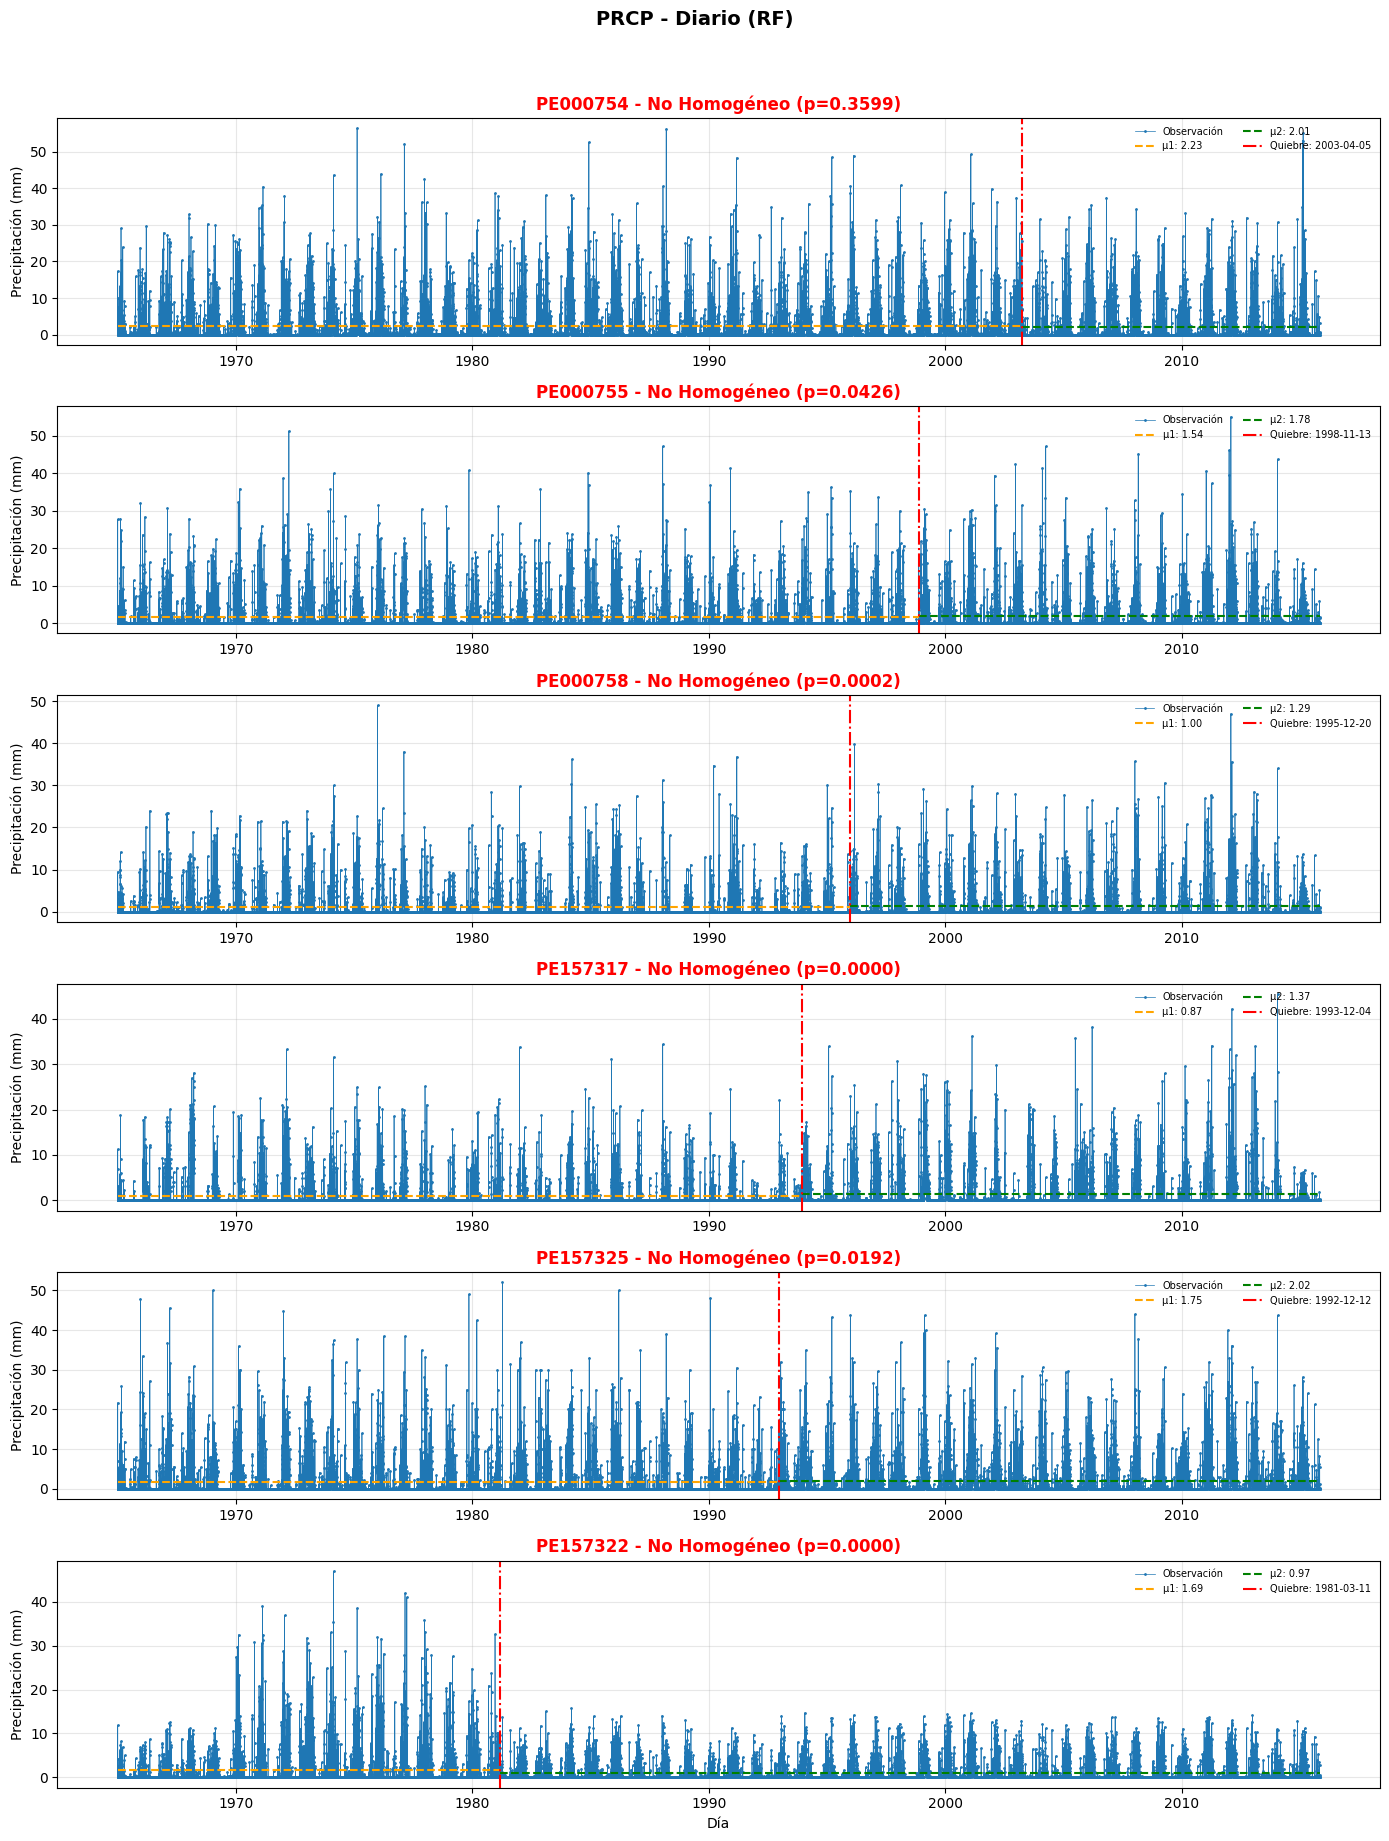


  Análisis Mensual (6 estaciones)...


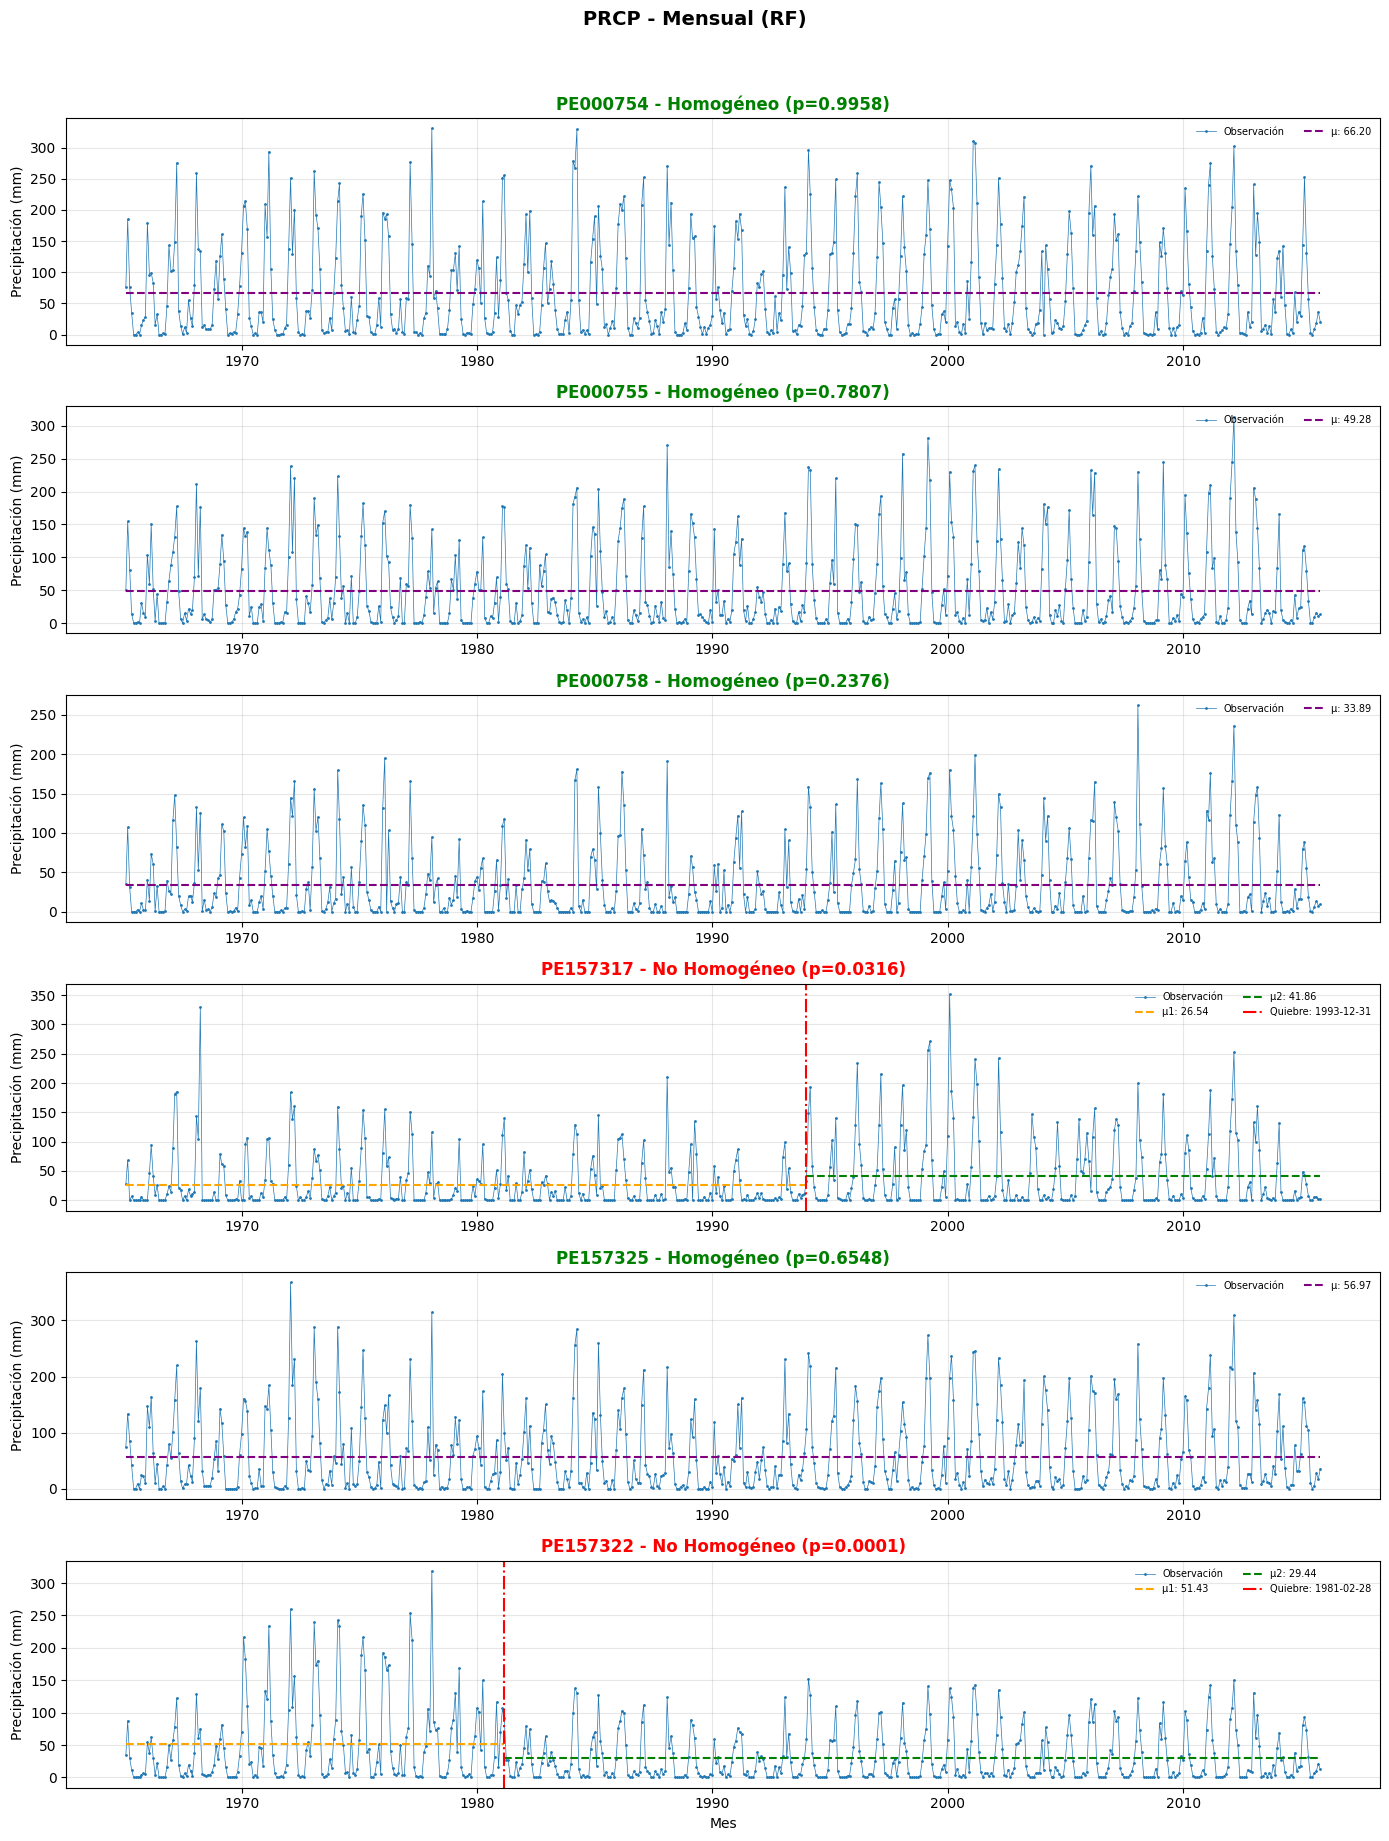


  Análisis Anual (6 estaciones)...


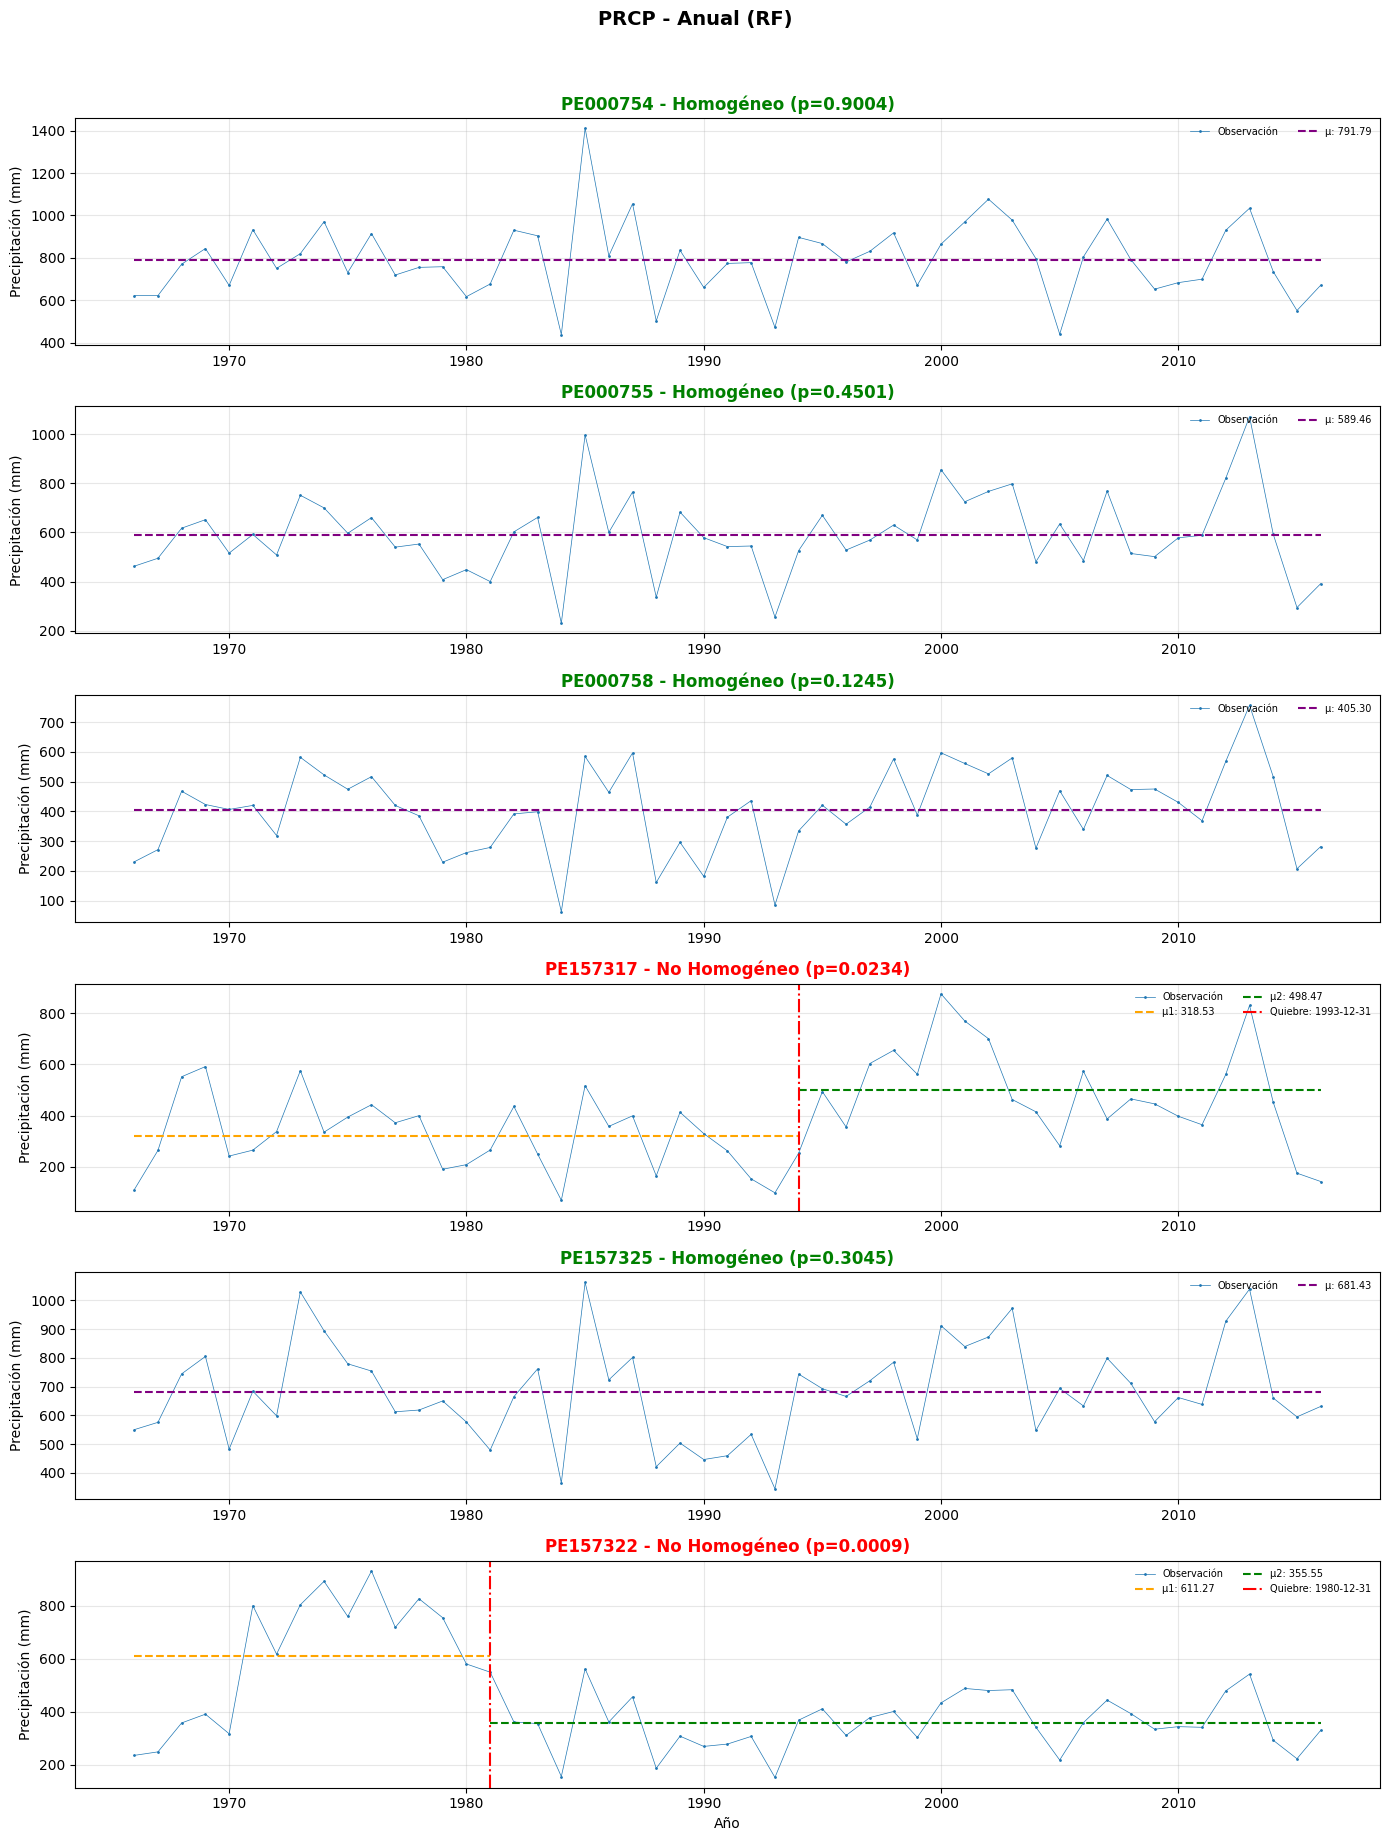


  HOMOGENEIDAD: TMAX

  Método: RF
  Estaciones: ['PE0001', 'PE0002', 'PE0003', 'PE0004', 'PE0005', 'PE0007']

  Análisis Diario (6 estaciones)...


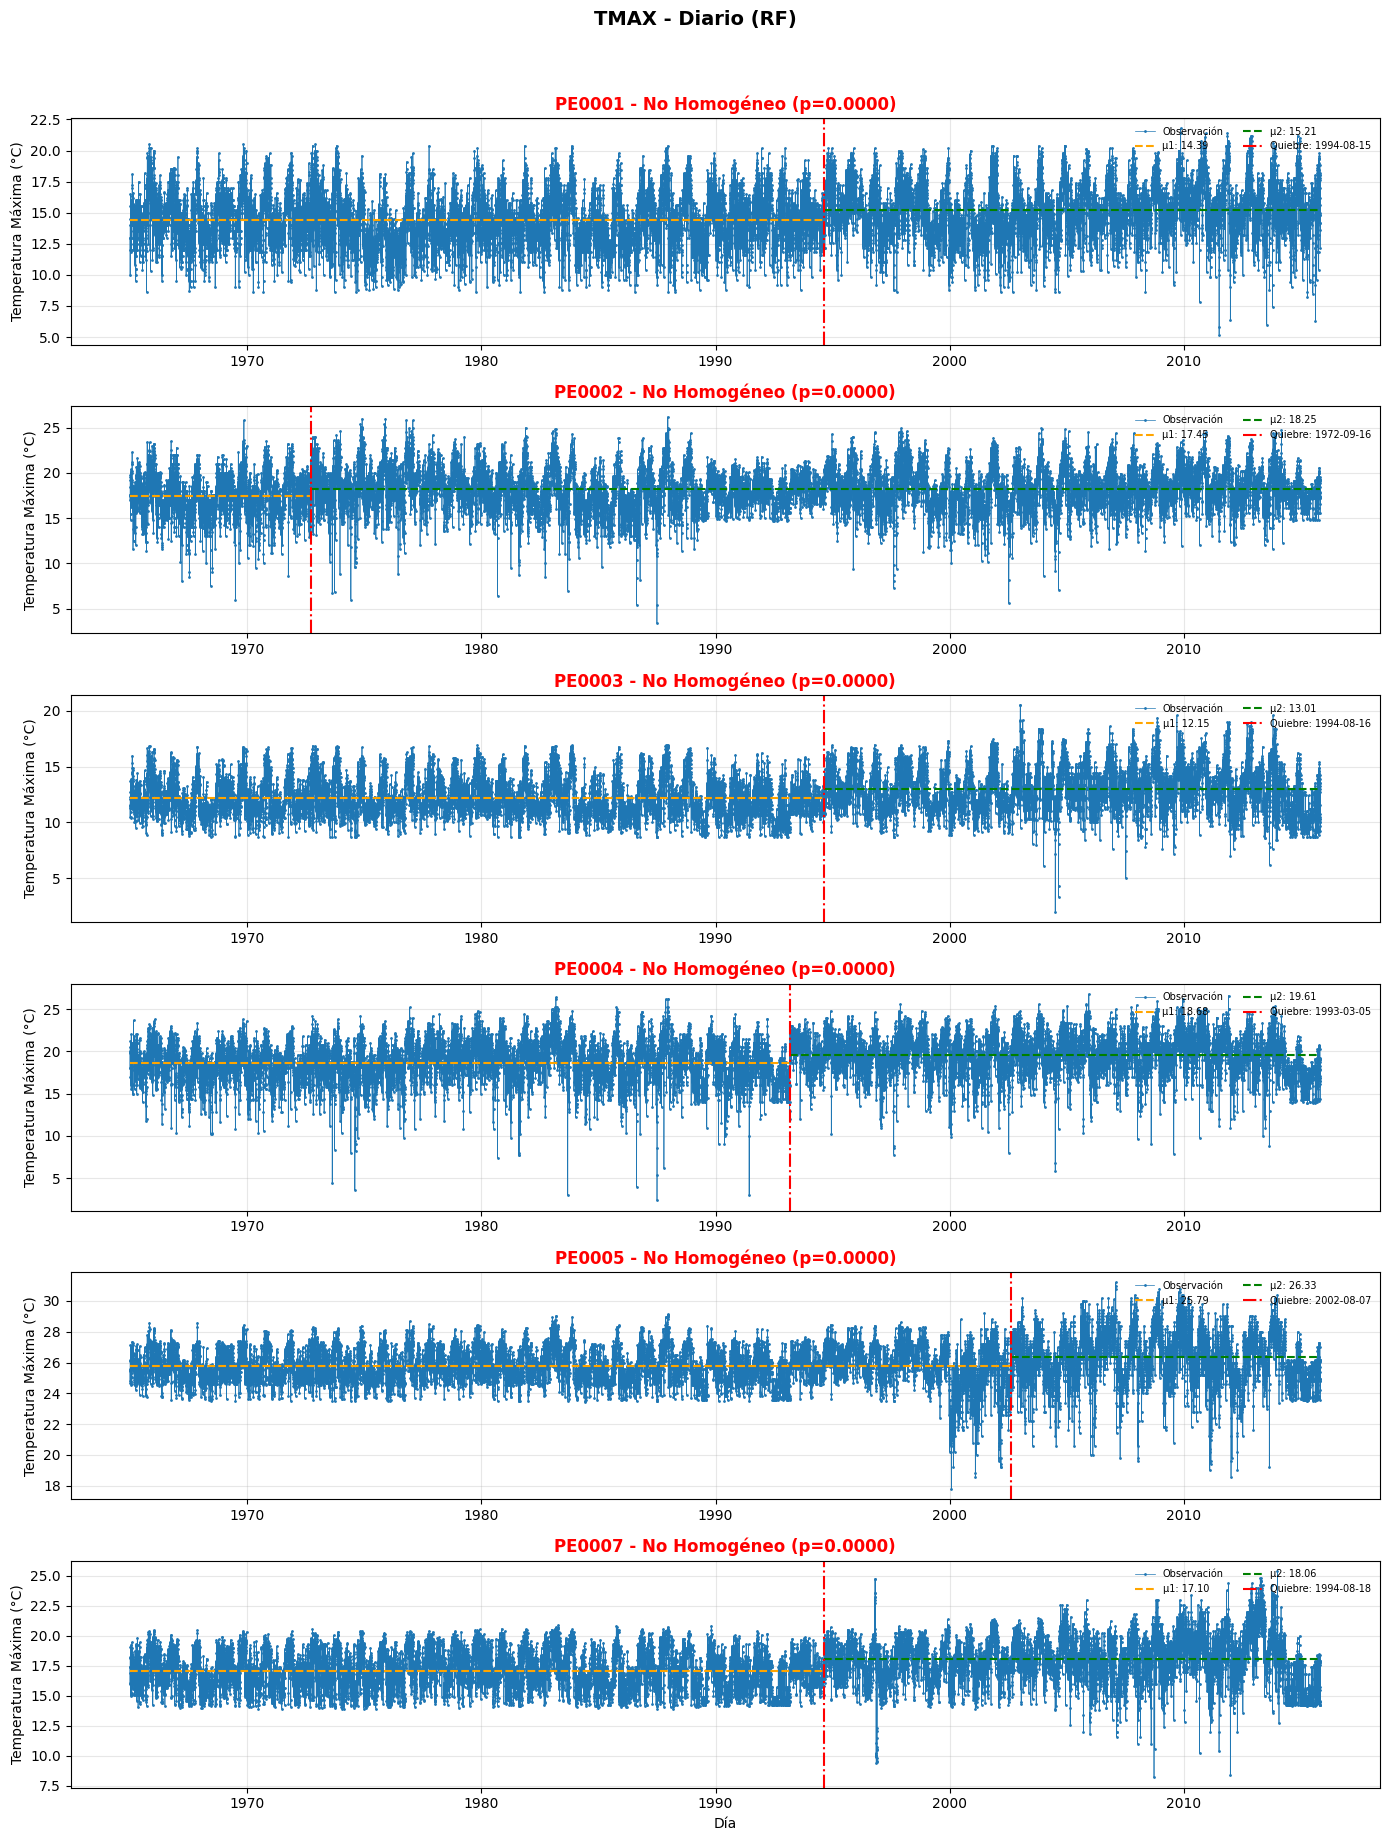


  Análisis Mensual (6 estaciones)...


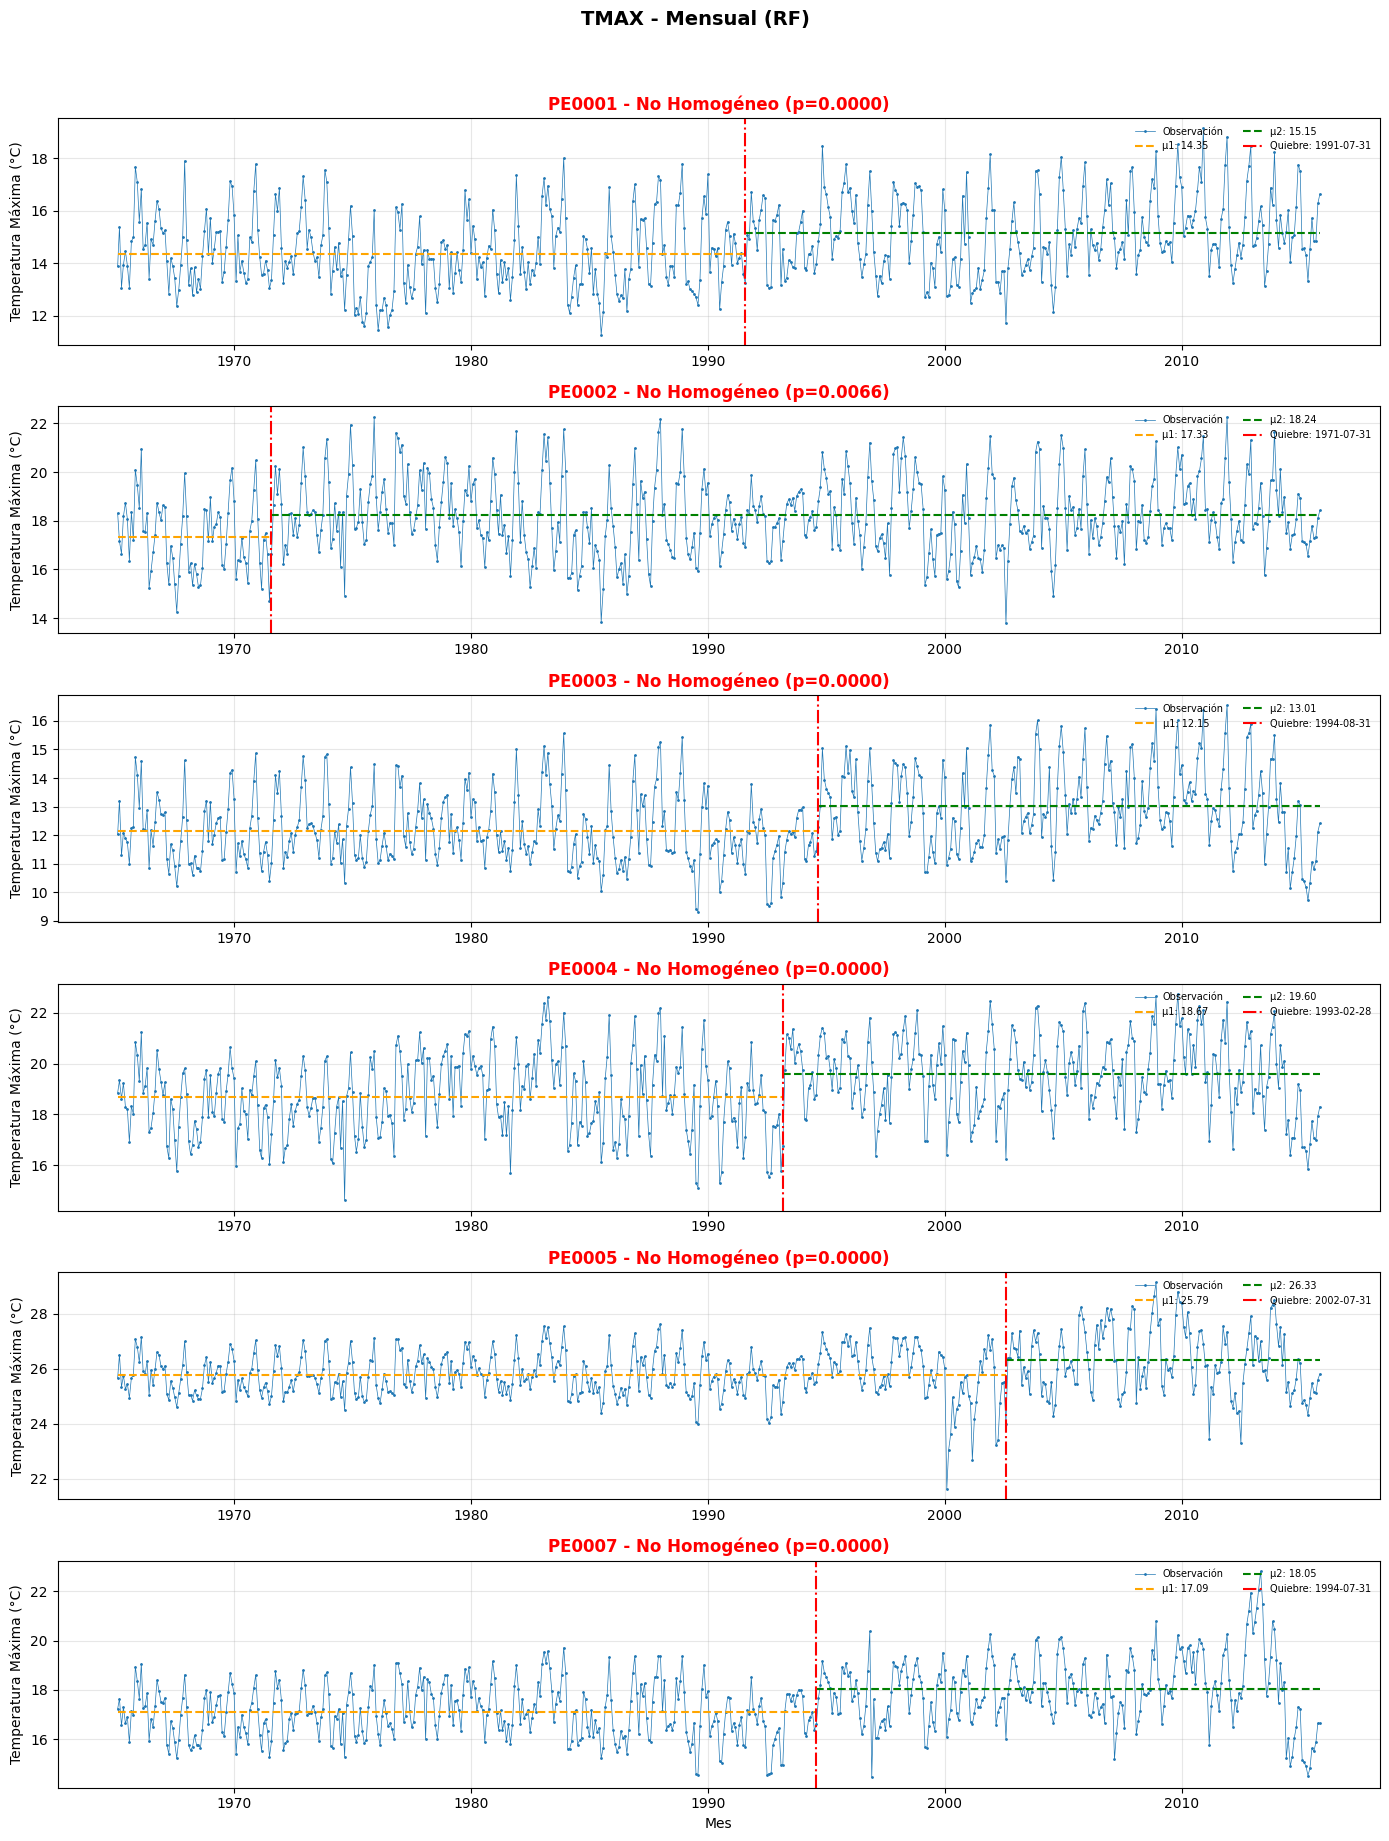


  Análisis Anual (6 estaciones)...


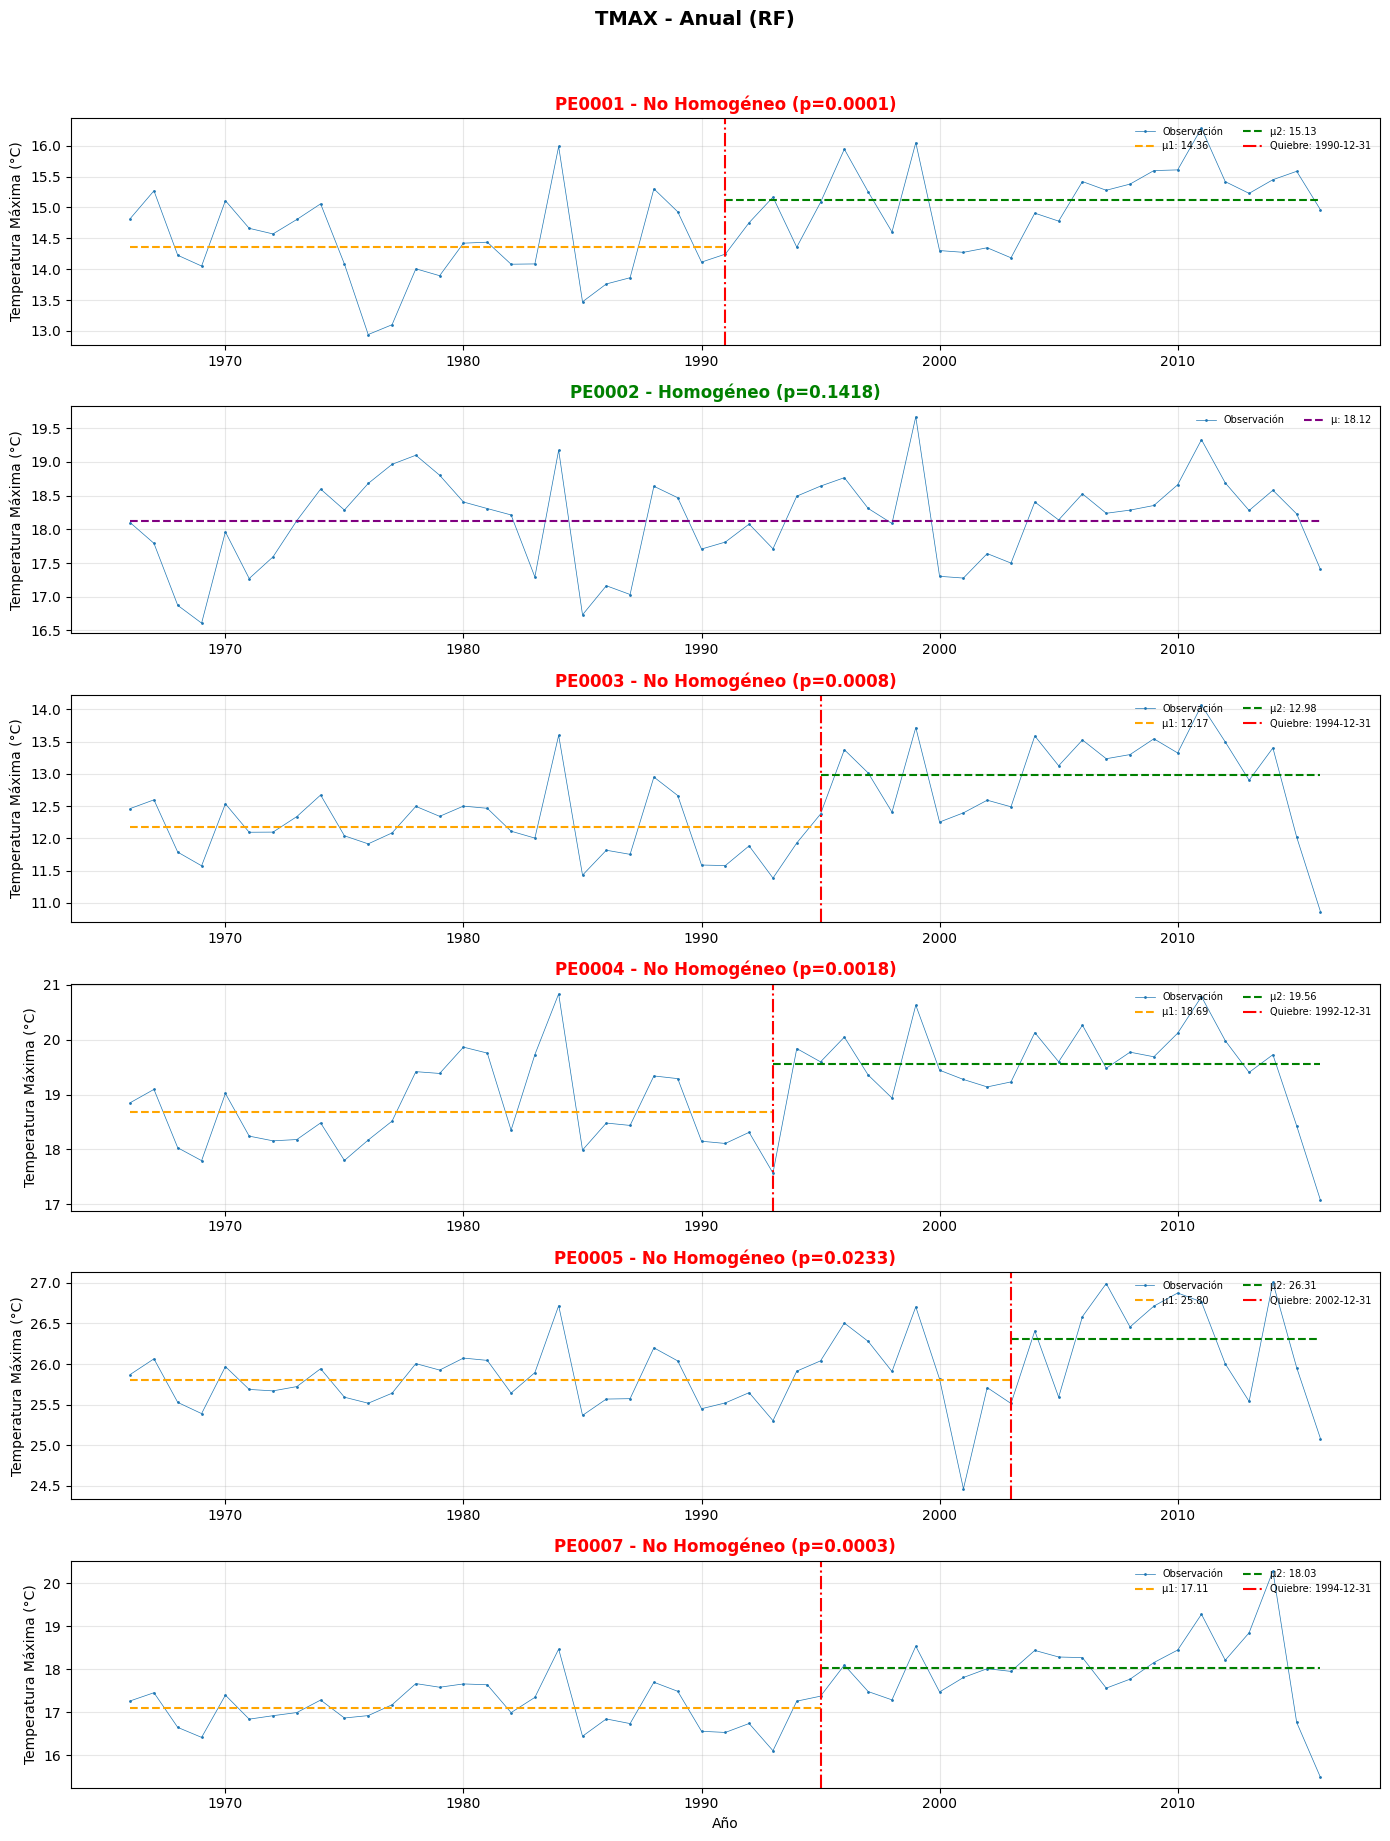


  HOMOGENEIDAD: TMIN

  Método: RF
  Estaciones: ['PE0001', 'PE0002', 'PE0004', 'PE0005', 'PE0007', 'nan']

  Análisis Diario (6 estaciones)...


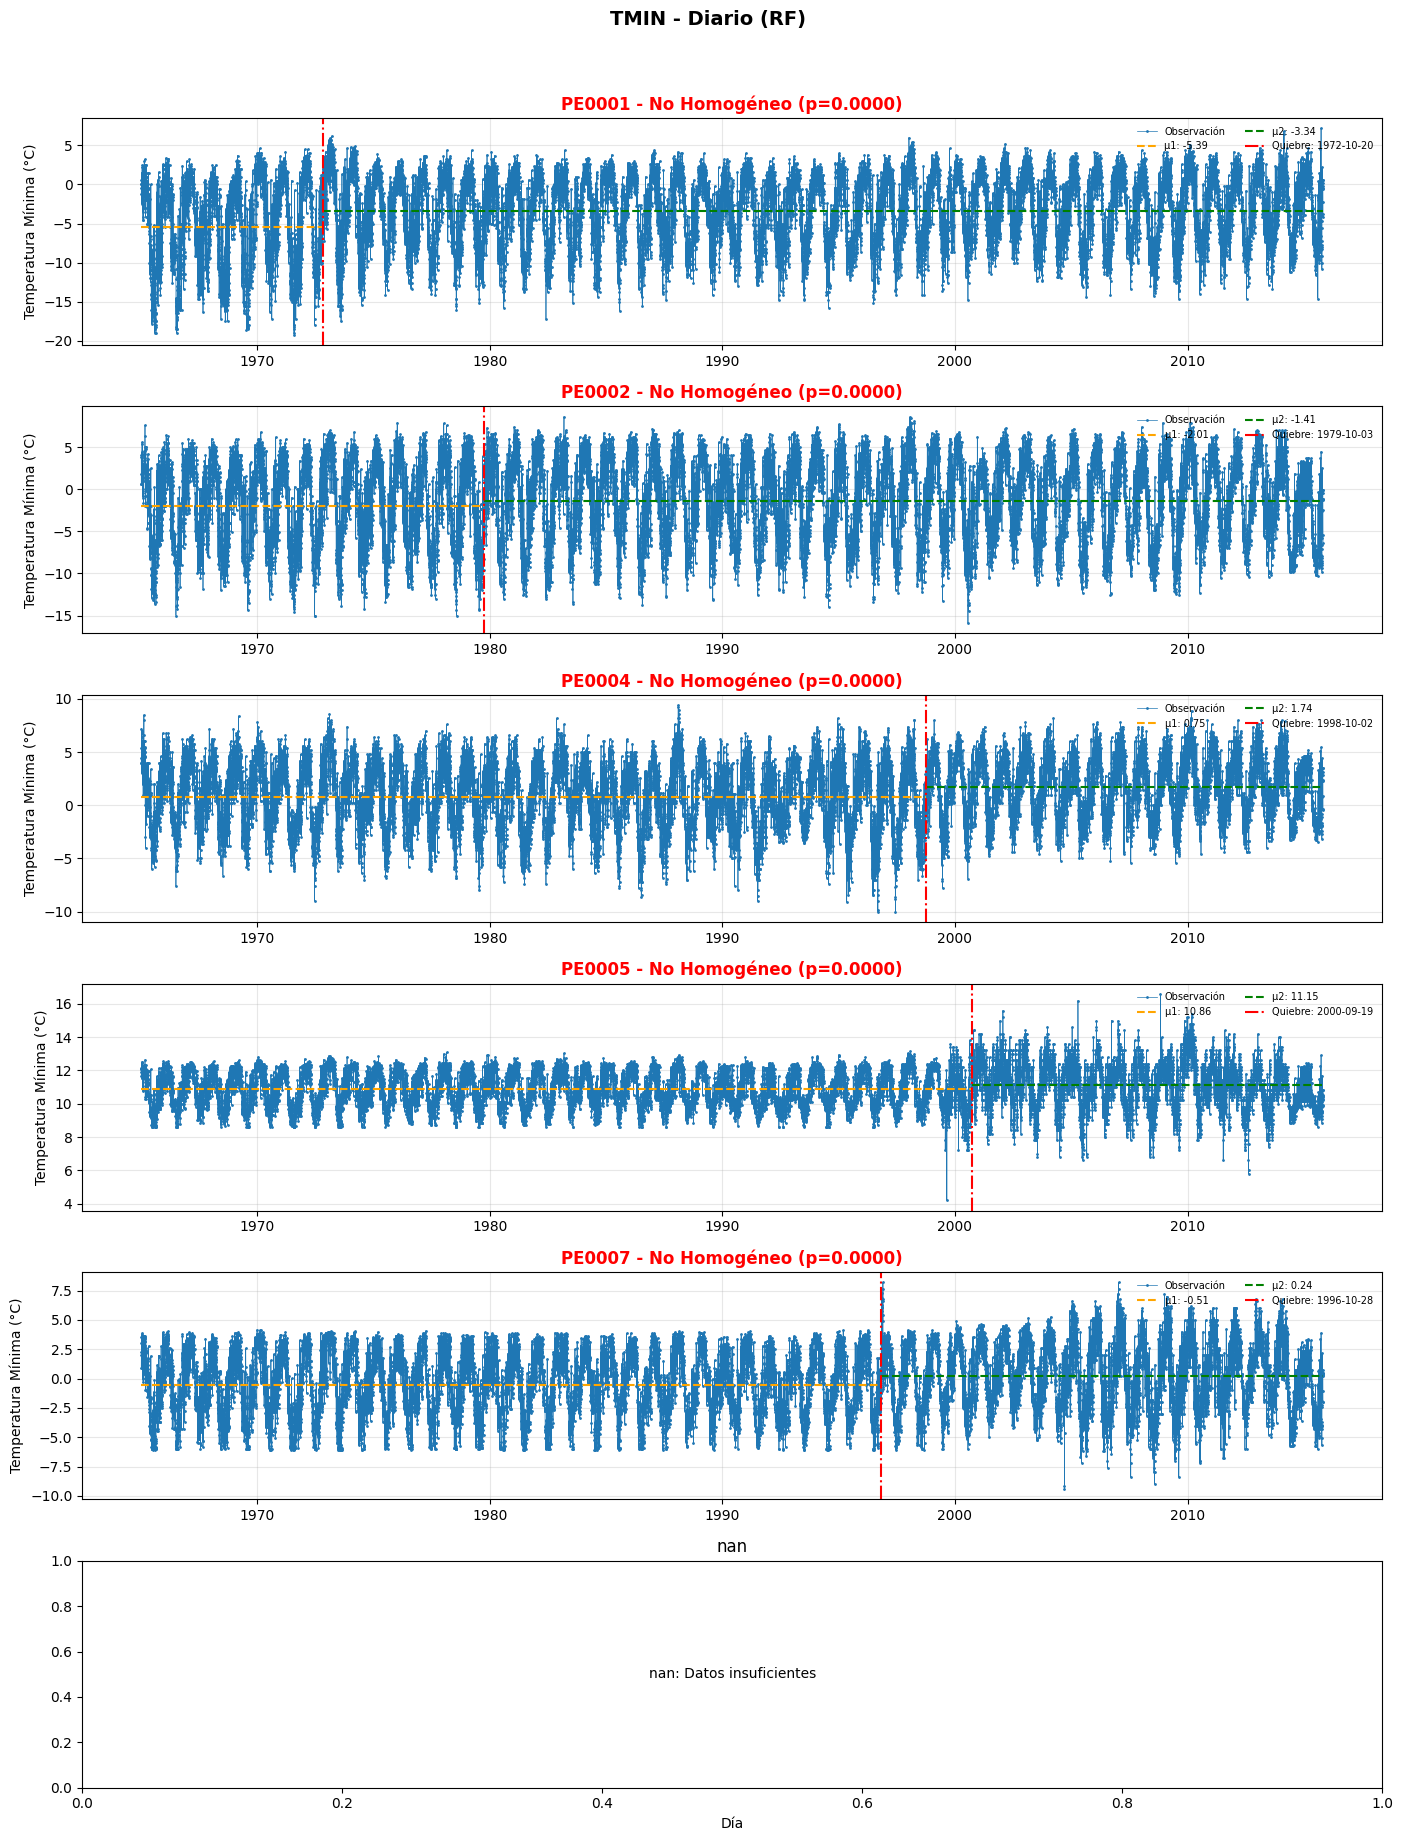


  Análisis Mensual (6 estaciones)...


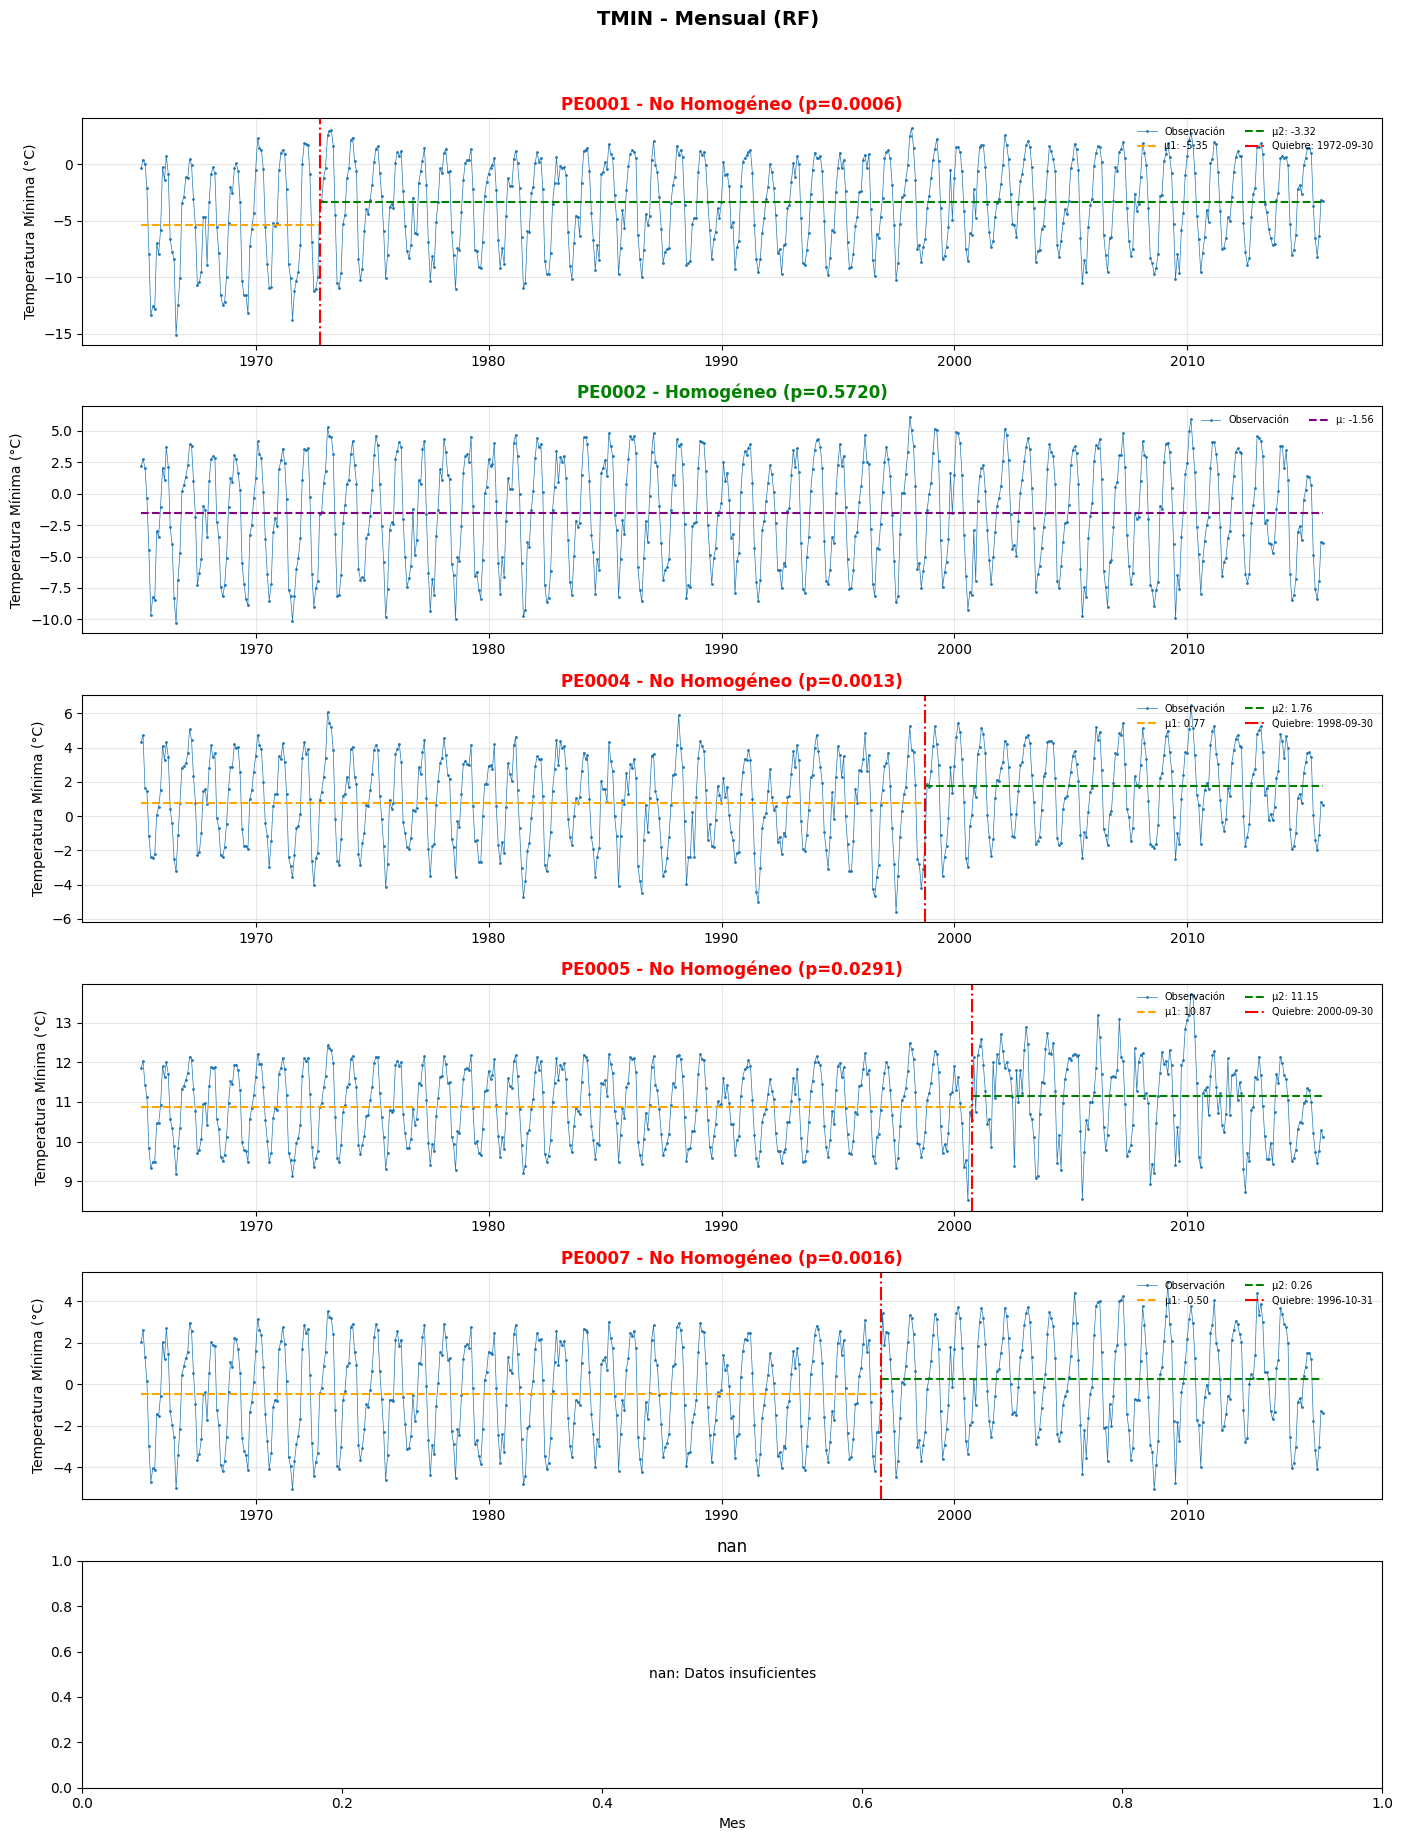


  Análisis Anual (6 estaciones)...


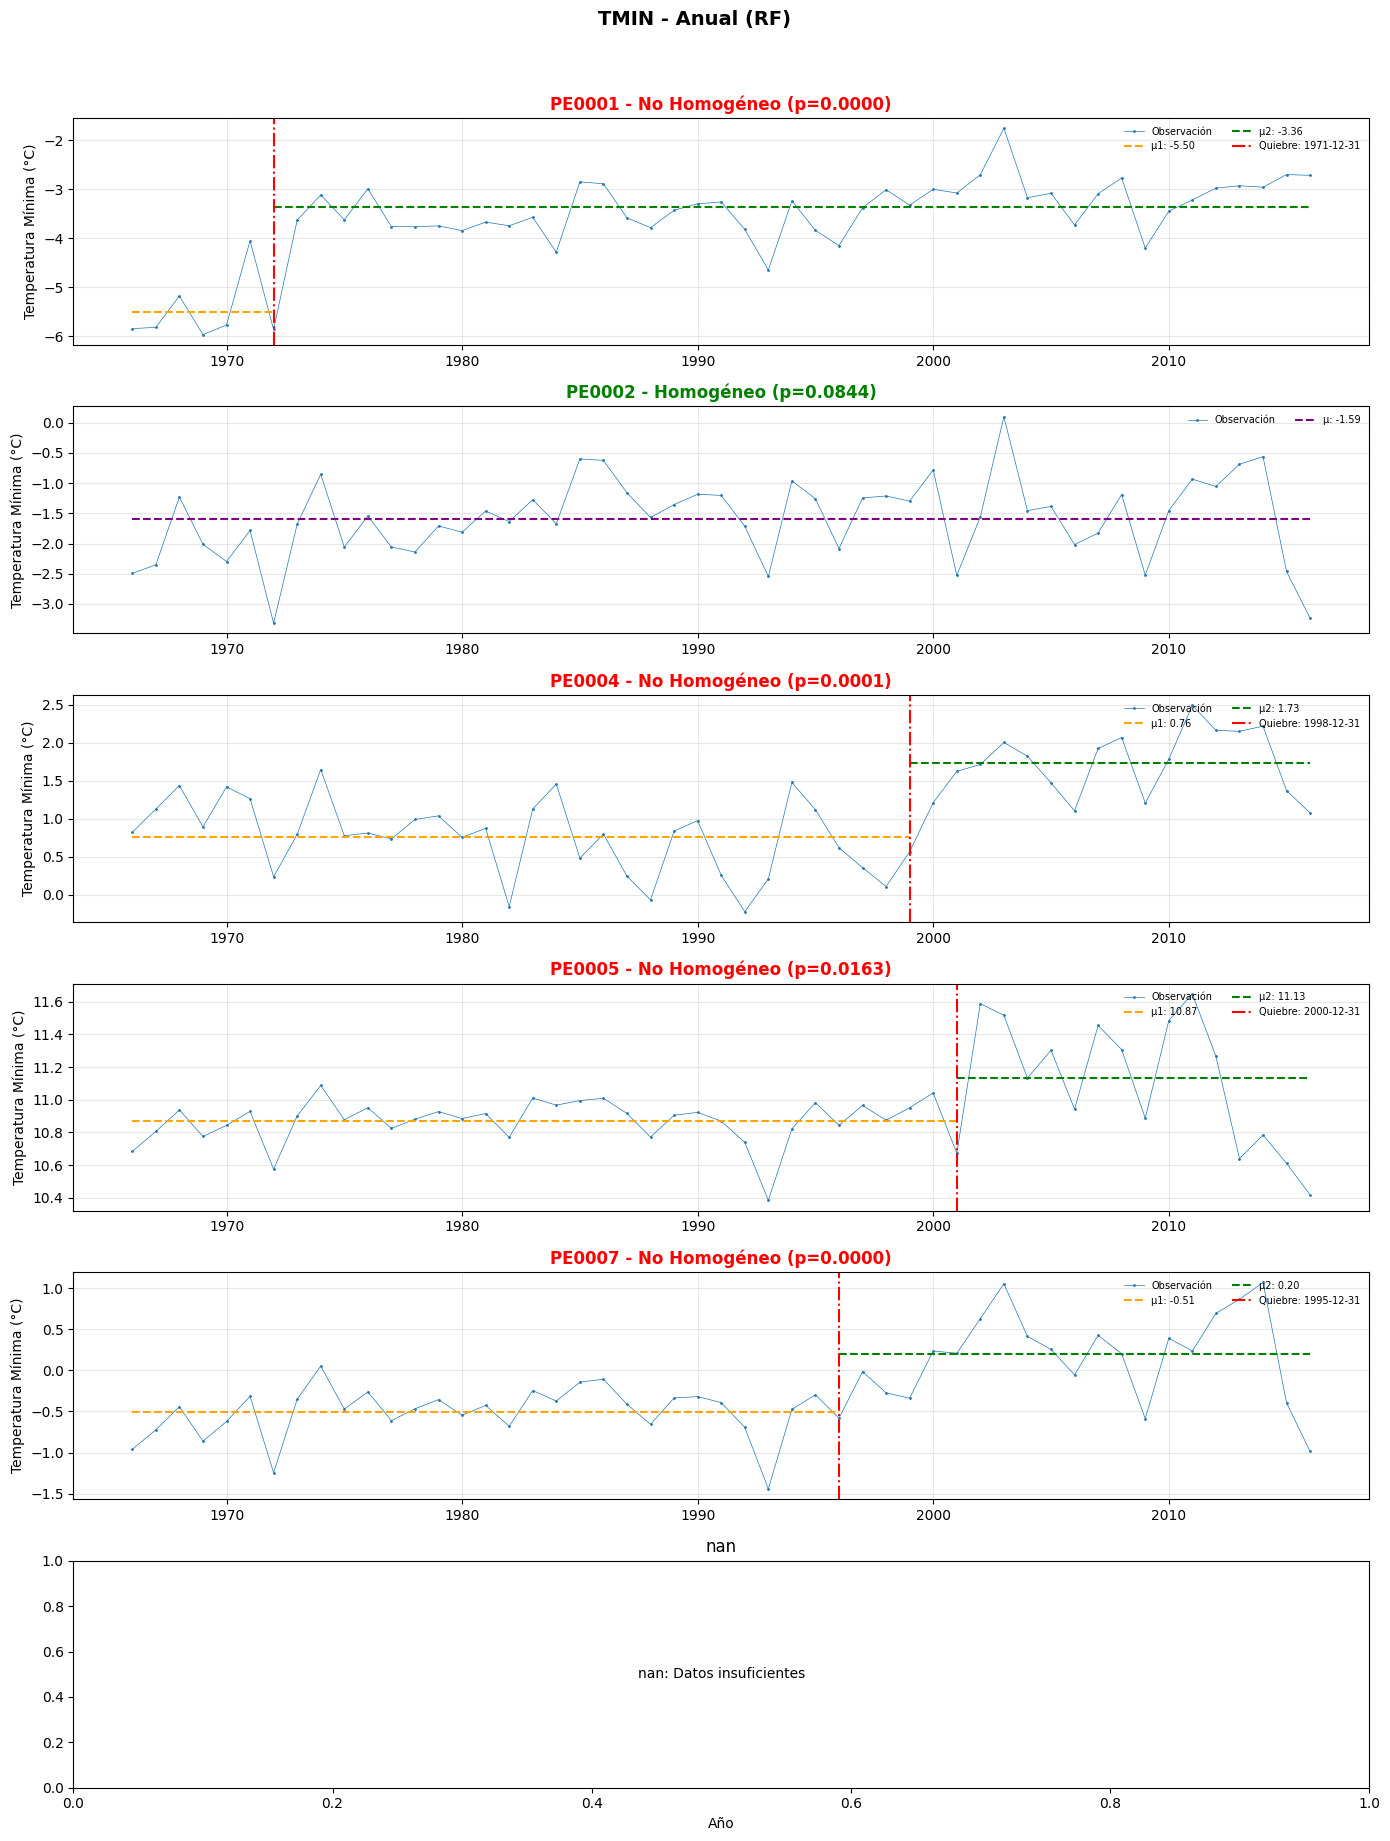


  HOMOGENEIDAD: FLOW

  Método: RF
  Estaciones: ['PE230501', 'PE204604', 'PE204619', 'PE204601', 'PE204603']

  Análisis Diario (5 estaciones)...


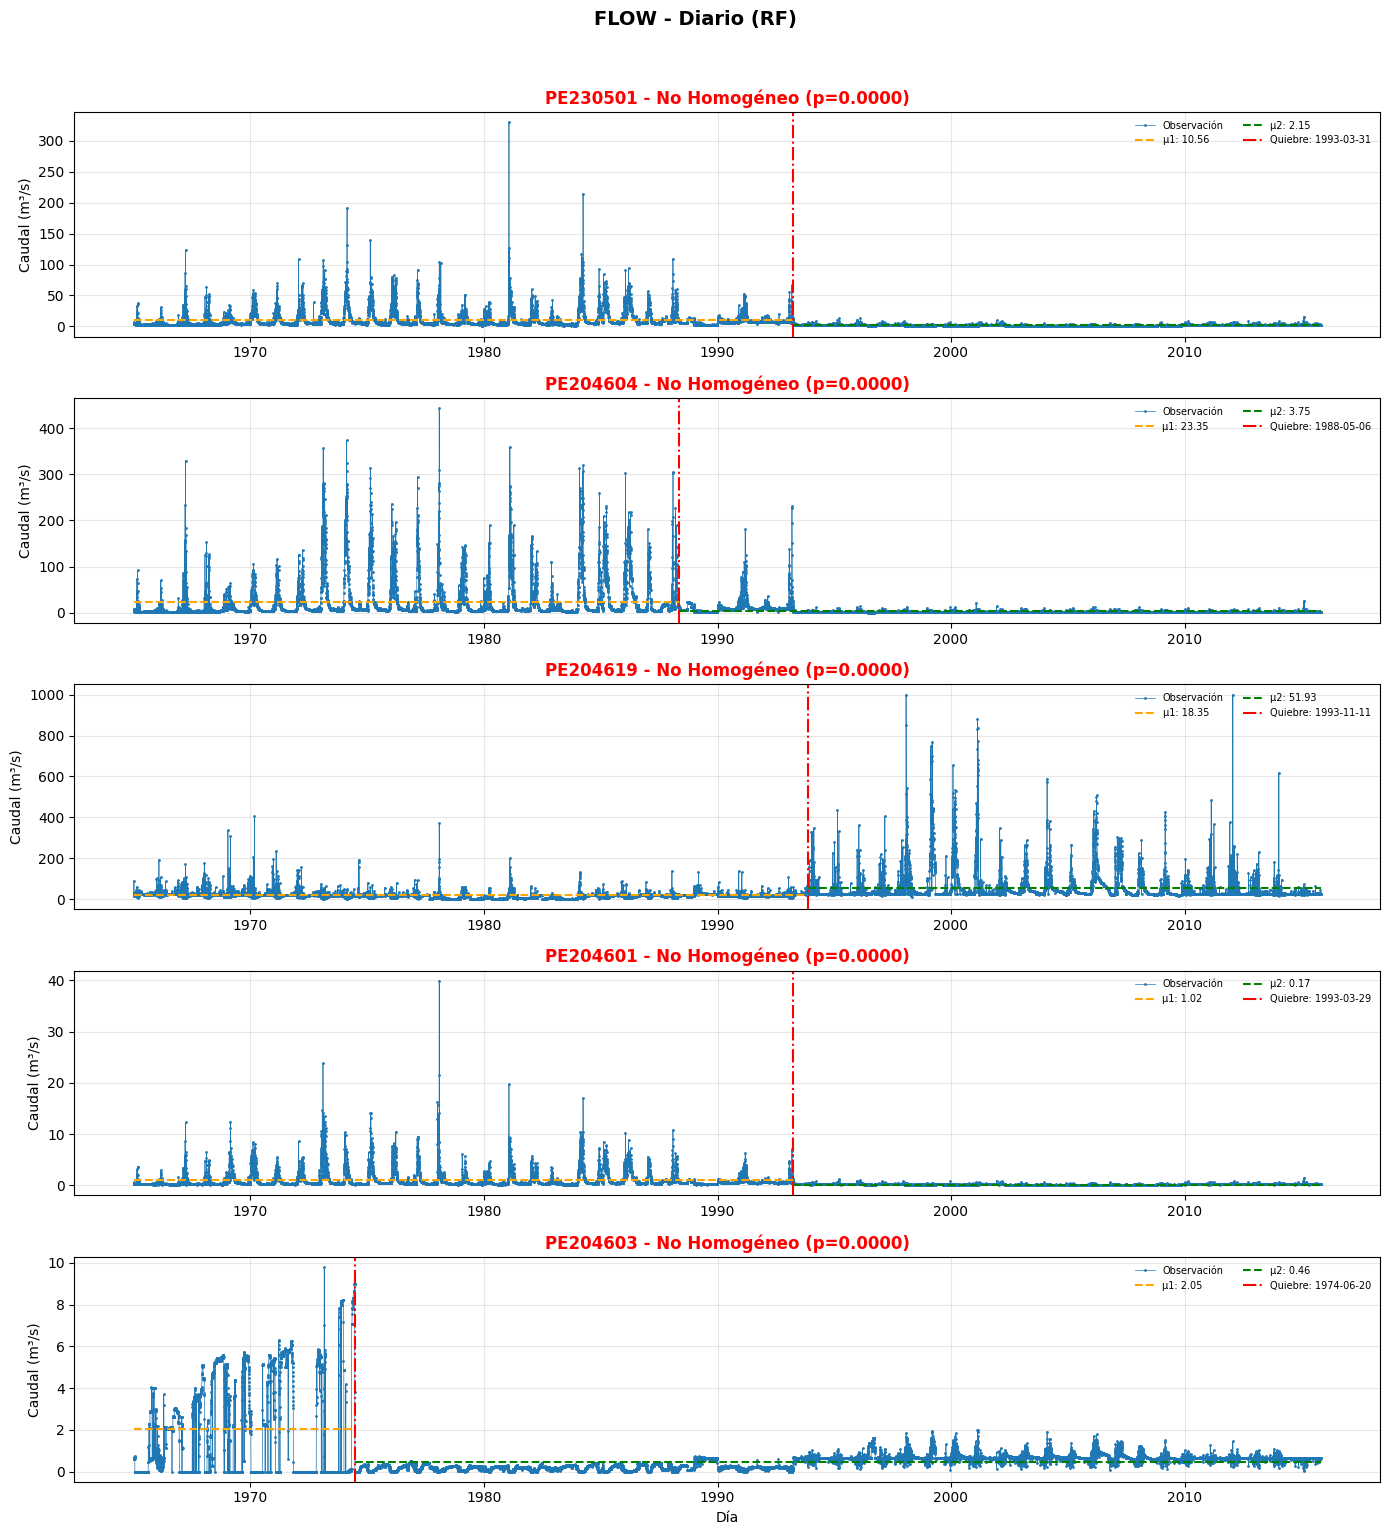


  Análisis Mensual (5 estaciones)...


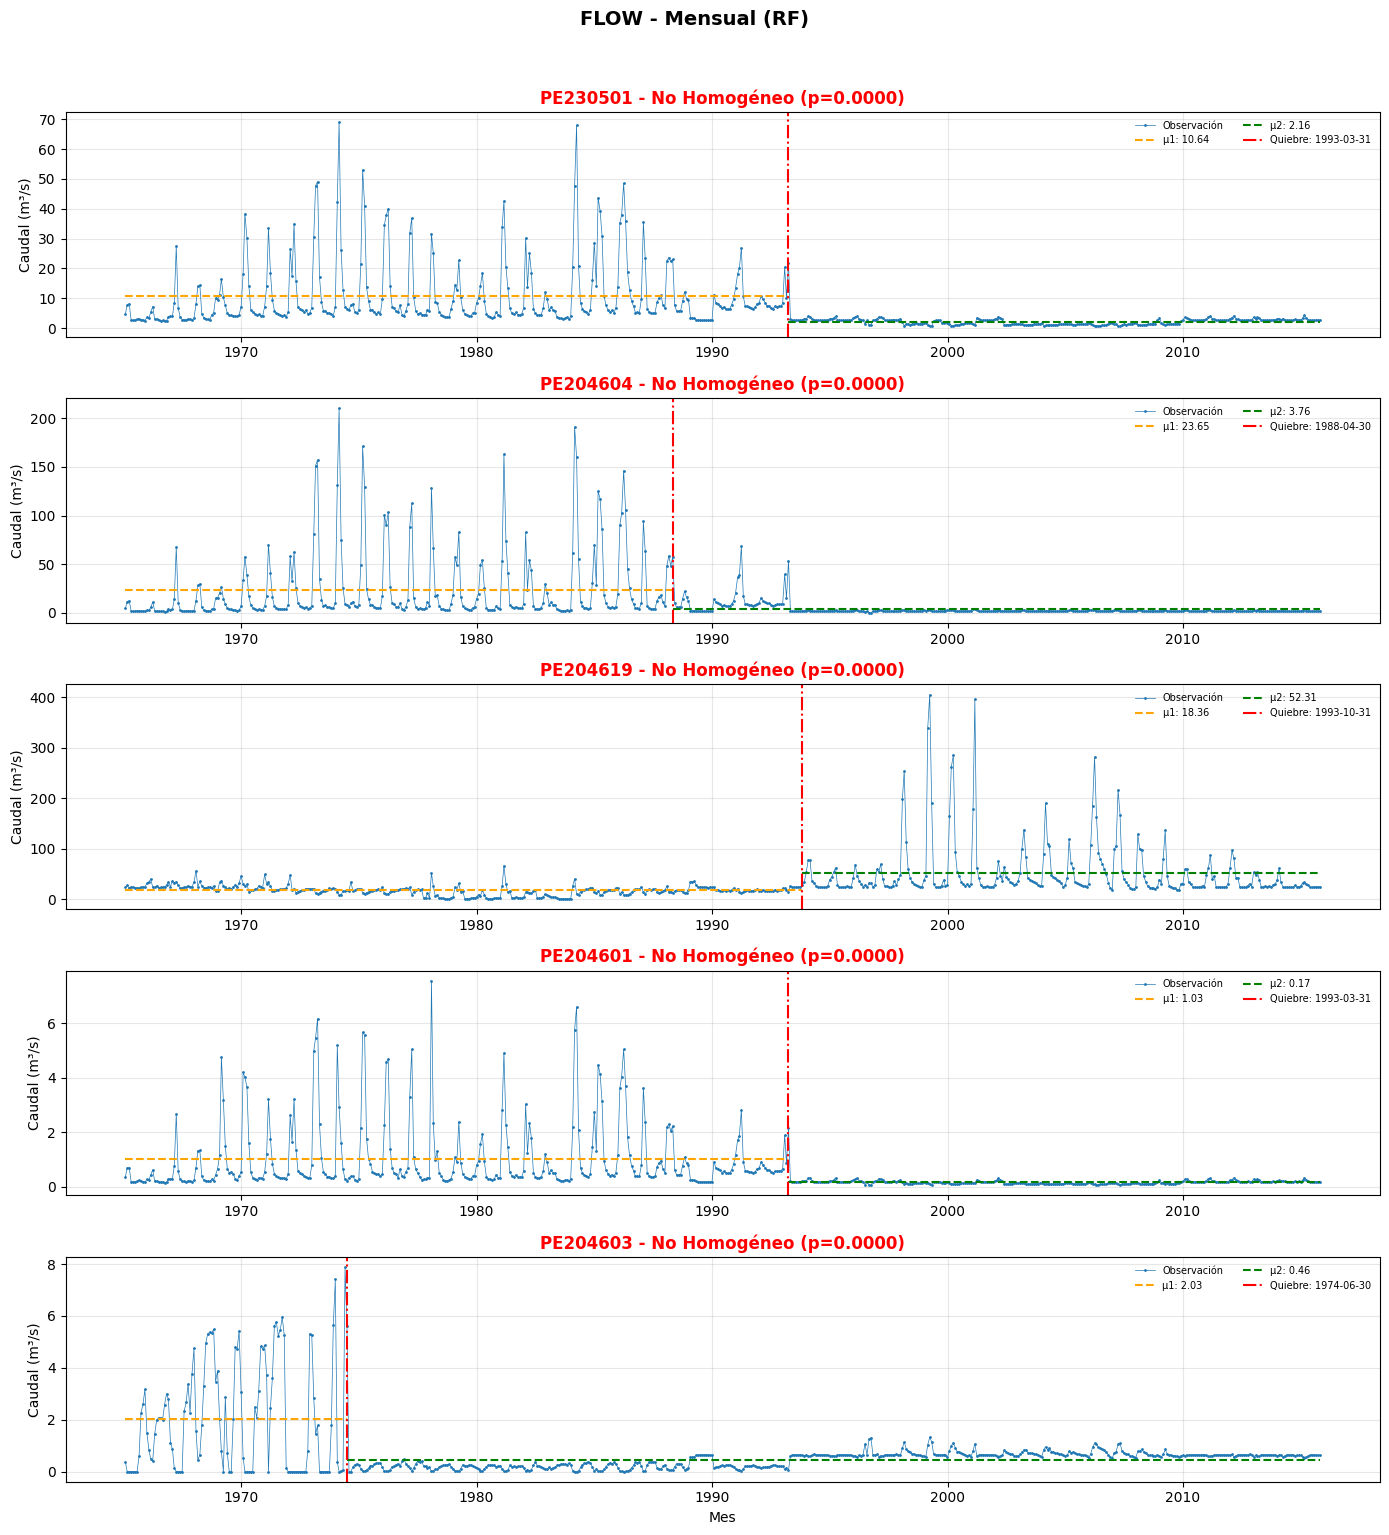


  Análisis Anual (5 estaciones)...


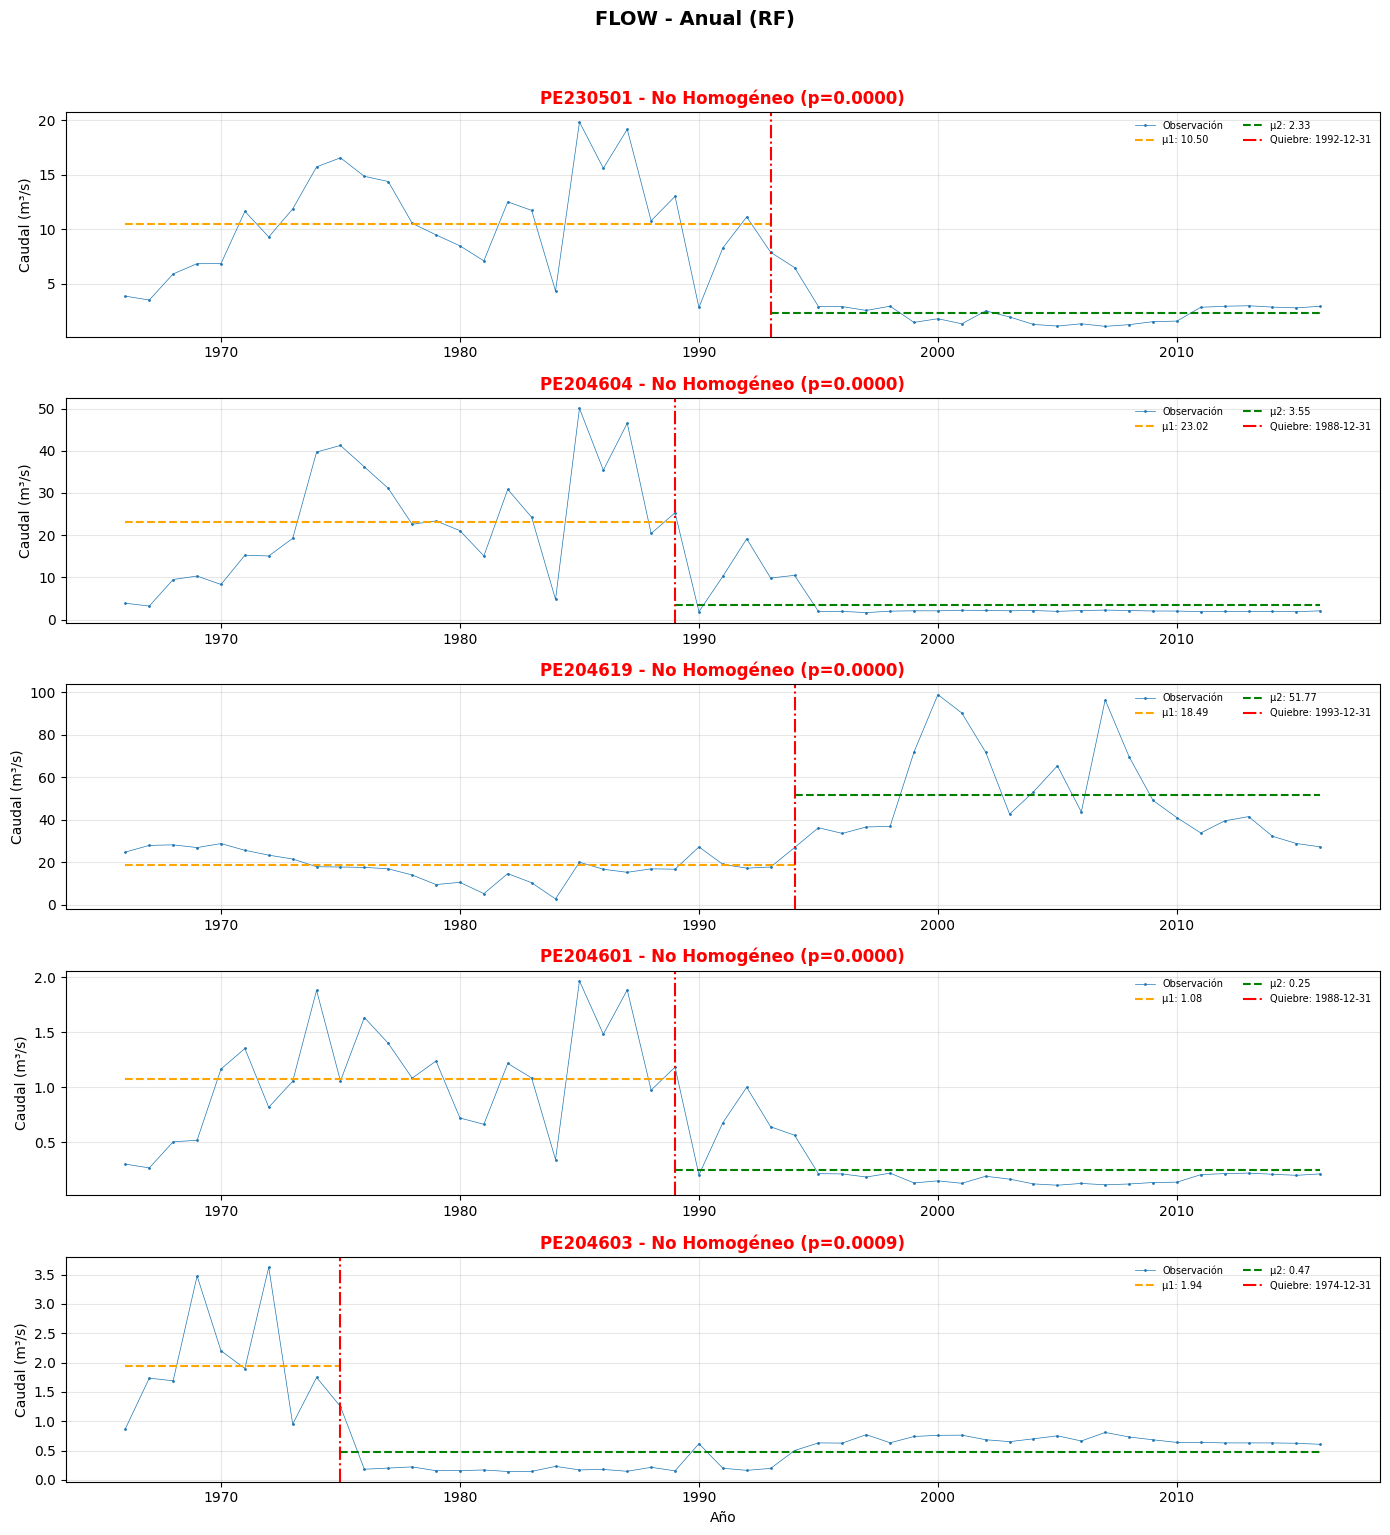

In [8]:
# Análisis de homogeneidad para todas las variables
homogeneity_results = homogeneity.analyze_all_variables(
    config, all_results, 
    n_stations=6,  # Número de estaciones por variable
    frequencies=['D', 'ME', 'YE']  # Diario, Mensual, Anual
)

In [9]:
# Resumen de homogeneidad
df_homogeneity = homogeneity.summarize_homogeneity(homogeneity_results)
display(df_homogeneity)

Variable Método Frecuencia  Estación  Homogéneo  p-value
0      prcp     RF          D  PE000754      False   0.3599
1      prcp     RF          D  PE000755      False   0.0426
2      prcp     RF          D  PE000758      False   0.0002
3      prcp     RF          D  PE157317      False   0.0000
4      prcp     RF          D  PE157325      False   0.0192
..      ...    ...        ...       ...        ...      ...
61     flow     RF         YE  PE230501      False   0.0000
62     flow     RF         YE  PE204604      False   0.0000
63     flow     RF         YE  PE204619      False   0.0000
64     flow     RF         YE  PE204601      False   0.0000
65     flow     RF         YE  PE204603      False   0.0009

[66 rows x 6 columns]

## 8. Exportar Resultados

In [10]:
# Exportar todos los resultados a CSV
pipeline.export_results_to_csv(config, all_results)


=== EXPORTANDO RESULTADOS ===

Exportado: ../output\DATOS_IMPUTADOS_prcp_RF.csv
Exportado: ../output\DATOS_IMPUTADOS_tmax_RF.csv
Exportado: ../output\DATOS_IMPUTADOS_tmin_RF.csv
Exportado: ../output\DATOS_IMPUTADOS_flow_RF.csv

¡Exportación completa!
